
|Authors Name|ID      |
|------------|------- |
|Ben Allen   |18044679|
|Johney Jijin|18032679|
|Jamie Scott |18041508|

###### Imports and defaults

In [1]:
from IPython.core.display import display, HTML, Markdown as md
display(HTML("""<style>.container { width:100% !important; } p, ul {max-width: 40em;} .rendered_html table { margin-left: 0; } .output_subarea.output_png { display: flex; justify-content: center;}</style>"""))
import matplotlib.pyplot as plt
from pylab import rcParams
import pandas as pd
import seaborn as sns
import numpy as np
import statsmodels.formula.api as smf


rcParams['figure.dpi'] = 350
rcParams['axes.labelsize'] = 'large'
rcParams['xtick.labelsize'] = 20
rcParams['ytick.labelsize'] = 20
rcParams['lines.linewidth'] = 2
rcParams['font.size'] = 18

%matplotlib inline
sns.set_style('darkgrid')
pd.set_option('max_columns', 100)
pd.set_option('max_rows', 20)

---

<center style="background: #f8f8f8;padding: 1rem;padding-bottom: 2.5rem;border-radius: 8px;">
<a id="Home"></a>

# "Could he/they/she do it on a cold, wet night in Stoke"
## The myth of the unglamorous away fixture.

</center>

- [Introduction](#Introduction)
- [Research Question](#Research_Question)
- [Importing Data](#Importing_Data)
- [Cleaning and Wrangling](#Cleaning_and_Wrangling)
    - [Integrating Weather Data](#Weather)
    - [Creating Derived Features](#Derived_Features)
- [EDA](#EDA)
- [Regression](#Regression)
- [Conclusion](#Conclusion)
- [Limitations](#Limitation)
- [Data Sources](#Data_Sources)
- [References](#References)

- [Stuff we dont need just yet](#Extras)


- Import datasets
- Clean datasets
- whatever else

<a id="Introduction"></a>
## Introduction 

Nine years ago, just a few days before Christmas at the midpoint in the 2010/11 season, football commentator Andy Gray gave the football lexicon a small but lasting gift. He and Richard Keys were filling the time before kickoff in the televised Monday night match discussing the relative merits of two of the greatest players of all time, Lionel Messi and Cristiano Ronaldo who were going head-to-head for yet another award.

Depsite being full of praise for Messi, who played (and still does) for Barcelona in Spain's La Liga, Gray suggested the player many believe the best to play the game "would struggle on a cold night at the Britannia Stadium"$^{1}$, where Stoke City play their home games. For Stoke, it appeared a relatively generous assertion given they were hardly one of the best sides in England, let alone Europe.

The quote morphed and took on a life of its own. "Can he/they/she do it on a cold, wet Wednesday night in Stoke" has became a sometimes serious, often tongue-in-cheek benchmark for quality, especially in unfamiliar or unpleasant conditions even beyond the realm of football. Showing how serious the notion is sometimes taken, the Daily Telgraph named it one of the ten most enduring football debates,$^{2}$ while at the other end of the scale, the line even spawned its own video game.$^{3}$

Stoke spent 10 seasons in the top flight before being relegated to the second tier of English football at the end of the 2017/18 season but the meme lives on. Recently when English side Liverpool knocked Barcelona out of the European Champions League, many twitter users saw it as evidence that Messi could not in fact do it on a cold night in Stoke, setting aside the fact that Stoke and Liverpool are in fact different places (and Messi and his teammates have knocked plenty of English and Scottish sides out of the Champions League). Nonetheless it piqued our interest in the math behind the myth.

In [2]:
from IPython.core.display import HTML 
HTML("<iframe src=https://www.telegraph.co.uk/sport/11611106/The-10-most-enduring-football-debates.html?frame=3307440 width=1200 height=600></iframe>")

/anaconda3/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


<a id="Research_Question"></a>
## Research question
Driving this report is the exploration of the following question:
> Is there any validity to the notion that an away fixture on a cold, wet Wednesday night in Stoke is a tough fixture?

Firstly we'll examine some of the reasons why Stoke of all places was singled out in this otherwise throwaway comment. Is it particularly cold or wet? Are there other factors that might contrbute to it being a tough away match?

Next, we'll dive deeper into just how difficult a fixture away to Stoke was, based on results from their ten year stay on the Premier League. Did they become harder to beat when in cold or wet weather? Or during the week instead of on the weekend? Or maybe a given a combination of those things. Crucially, were they harder to beat than other teams.


<a id="Importing_Data"></a>
## Importing data

The Premier League data we worked with came from two sources with essentially the same core information but two important differences. One had more detailed information including fouls, shot along with red and yellow cards while another had attendance and a key ingredient for our analysis... kickoff time.

In [3]:
#import smaller dataset from 07/08 - 17/18 that contains time info
DatasetOne = pd.read_csv("./epl_data.csv", usecols=[1,2,3,4,6,7,8,9])

#import bigger dataset that has extra info but not time data
DatasetTwo = pd.read_csv("./EPL 2000-2018.csv")

display(md("#### Dataset with time info"), DatasetOne.head())
display(md("#### Dataset with extra fixture info"), DatasetTwo.head())

#### Dataset with time info

,Team_Home,Team_Away,HG,AG,Season,Date_Time,Referee_Name,Att
0,Sunderland,Tottenham Hotspur,1,0,2007/2008,11/08/2007 12:45,Alan Wiley,43967
1,Bolton Wanderers,Newcastle United,1,3,2007/2008,11/08/2007 15:00,Chris Foy,25414
2,Derby County,Portsmouth,2,2,2007/2008,11/08/2007 15:00,Mike Dean,32176
3,Everton,Wigan Athletic,2,1,2007/2008,11/08/2007 15:00,Mark Clattenburg,39220
4,Middlesbrough,Blackburn Rovers,1,2,2007/2008,11/08/2007 15:00,Andre Marriner,25058


#### Dataset with extra fixture info

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,Season
0,19/08/00,Charlton,Man City,4.0,0.0,H,2.0,0.0,H,Rob Harris,17.0,8.0,14.0,4.0,13.0,12.0,6.0,6.0,1.0,2.0,0.0,0.0,00-01
1,19/08/00,Chelsea,West Ham,4.0,2.0,H,1.0,0.0,H,Graham Barber,17.0,12.0,10.0,5.0,19.0,14.0,7.0,7.0,1.0,2.0,0.0,0.0,00-01
2,19/08/00,Coventry,Middlesbrough,1.0,3.0,A,1.0,1.0,D,Barry Knight,6.0,16.0,3.0,9.0,15.0,21.0,8.0,4.0,5.0,3.0,1.0,0.0,00-01
3,19/08/00,Derby,Southampton,2.0,2.0,D,1.0,2.0,A,Andy D'Urso,6.0,13.0,4.0,6.0,11.0,13.0,5.0,8.0,1.0,1.0,0.0,0.0,00-01
4,19/08/00,Leeds,Everton,2.0,0.0,H,2.0,0.0,H,Dermot Gallagher,17.0,12.0,8.0,6.0,21.0,20.0,6.0,4.0,1.0,3.0,0.0,0.0,00-01


In [4]:
DatasetOne.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4180 entries, 0 to 4179
Data columns (total 8 columns):
Team_Home       4180 non-null object
Team_Away       4180 non-null object
HG              4180 non-null int64
AG              4180 non-null int64
Season          4180 non-null object
Date_Time       4180 non-null object
Referee_Name    4180 non-null object
Att             4180 non-null int64
dtypes: int64(3), object(5)
memory usage: 261.3+ KB


In [5]:
DatasetTwo.info()
#note extra non-null entry for season and floats instead of ints

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6461 entries, 0 to 6460
Data columns (total 23 columns):
Date        6460 non-null object
HomeTeam    6460 non-null object
AwayTeam    6460 non-null object
FTHG        6460 non-null float64
FTAG        6460 non-null float64
FTR         6460 non-null object
HTHG        6460 non-null float64
HTAG        6460 non-null float64
HTR         6460 non-null object
Referee     6460 non-null object
HS          6460 non-null float64
AS          6460 non-null float64
HST         6460 non-null float64
AST         6460 non-null float64
HF          6460 non-null float64
AF          6460 non-null float64
HC          6460 non-null float64
AC          6460 non-null float64
HY          6460 non-null float64
AY          6460 non-null float64
HR          6460 non-null float64
AR          6460 non-null float64
Season      6461 non-null object
dtypes: float64(16), object(7)
memory usage: 1.1+ MB


<a id="Cleaning_and_Wrangling"></a>
## Cleaning and Wrangling 

Working with two similar but slightly different dataframes required some  wrangling to get them into states suitable for merging, with different conventions used for naming the clubs and seasons in each.

The quality of the data was relatively good although there was one rogue row of NaNs and a fixture that was recorded with the incorrect score in one of the sources and that required some detective work to fix.

Later, weather data was integrated from an API and some new colums created to help with EDA, classification and/or regression. These features included whether the match was played on midweek or on a weekend, whether the away team was Stoke or someone else and if the weather was cold or wet.

In [6]:
#There's an extra non-null entry in the Season column - check if it's a rogue entry
DatasetTwo.Season.unique()

array(['00-01', '02-03', '03-04', '04-05', '05-06', '06-07', '07-08',
       '08-09', '09-10', '10-11', '11-12', '12-13', '13-14', '14-15',
       '15-16', '16-17', '17-18'], dtype=object)

In [7]:
# DatasetTwo.isnull().sum()

In [8]:
#find row with extra entry 
DatasetTwo[DatasetTwo.HomeTeam.isnull()]

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,Season
5320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14-15


In [9]:
#make sure there's 380 fixtures for the 14-15 season. There's 381, we can delete.
DatasetTwo[DatasetTwo.Season == '14-15'].count()

Date        380
HomeTeam    380
AwayTeam    380
FTHG        380
FTAG        380
FTR         380
HTHG        380
HTAG        380
HTR         380
Referee     380
           ... 
AST         380
HF          380
AF          380
HC          380
AC          380
HY          380
AY          380
HR          380
AR          380
Season      381
Length: 23, dtype: int64

In [10]:
#Delete rows to ensure dataframes are same size
SeasonstoDelete = ['00-01', '02-03', '03-04', '04-05', '05-06', '06-07']
RowsToDelete = list(row for row in list(DatasetTwo.index) if DatasetTwo.Season[row] in SeasonstoDelete)
DatasetTwo.drop(RowsToDelete+[5320], inplace=True)

#delete an unnecessary column in dataset two
del DatasetTwo['Referee']

In [11]:
DatasetOne.Season.unique()

array(['2007/2008', '2008/2009', '2009/2010', '2010/2011', '2011/2012',
       '2012/2013', '2013/2014', '2014/2015', '2015/2016', '2016/2017',
       '2017/2018'], dtype=object)

In [12]:
#renaming in DatasetOne for consistency with datasetTwo to help with merging
DatasetOne.columns = ['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'Season', 'Date_Time',
       'Referee', 'Att']

In [13]:
# dict to align season values between datasets
SeasonDict = {'2007/2008':'07-08', '2008/2009':'08-09', '2009/2010':'09-10', '2010/2011':'10-11', '2011/2012':'11-12', 
              '2012/2013':'12-13', '2013/2014':'13-14', '2014/2015':'14-15', '2015/2016':'15-16', '2016/2017':'16-17',
              '2017/2018':'17-18'}

#create a dict to align team names in HomeTeam and AwayTeam columns
differentnamesOne = [name for name in list(DatasetOne.HomeTeam.unique()) if name not in list(DatasetTwo.HomeTeam.unique())]
differentnamesTwo = [name for name in list(DatasetTwo.HomeTeam.unique()) if name not in list(DatasetOne.HomeTeam.unique())]

renameTeams = {}
for i, name in enumerate(differentnamesOne):
    renameTeams.update({differentnamesTwo[i]:differentnamesOne[i]})

DatasetOne.replace({'Season':SeasonDict}, inplace=True)
DatasetTwo.replace({'HomeTeam':renameTeams, 'AwayTeam':renameTeams}, inplace=True)

In [14]:
for col in list(DatasetTwo.columns):
    if DatasetTwo[col].dtype == 'float64':
        DatasetTwo[col] = DatasetTwo[col].astype('int64')

In [15]:
DatasetOne.head()

,HomeTeam,AwayTeam,FTHG,FTAG,Season,Date_Time,Referee,Att
0,Sunderland,Tottenham Hotspur,1,0,07-08,11/08/2007 12:45,Alan Wiley,43967
1,Bolton Wanderers,Newcastle United,1,3,07-08,11/08/2007 15:00,Chris Foy,25414
2,Derby County,Portsmouth,2,2,07-08,11/08/2007 15:00,Mike Dean,32176
3,Everton,Wigan Athletic,2,1,07-08,11/08/2007 15:00,Mark Clattenburg,39220
4,Middlesbrough,Blackburn Rovers,1,2,07-08,11/08/2007 15:00,Andre Marriner,25058


In [16]:
DatasetTwo.reset_index(drop=True, inplace=True)
DatasetTwo.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,Season
0,11/08/07,Aston Villa,Liverpool,1,2,A,0,1,A,10,17,6,7,18,11,4,2,4,2,0,0,07-08
1,11/08/07,Bolton Wanderers,Newcastle United,1,3,A,0,3,A,13,7,9,5,15,16,4,3,1,1,0,0,07-08
2,11/08/07,Derby County,Portsmouth,2,2,D,1,1,D,12,12,5,6,14,17,6,6,1,2,0,0,07-08
3,11/08/07,Everton,Wigan Athletic,2,1,H,1,0,H,12,14,8,4,8,13,6,2,0,0,0,0,07-08
4,11/08/07,Middlesbrough,Blackburn Rovers,1,2,A,1,0,H,10,4,6,4,16,16,13,3,3,4,0,0,07-08


In [17]:
DatasetOne.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4180 entries, 0 to 4179
Data columns (total 8 columns):
HomeTeam     4180 non-null object
AwayTeam     4180 non-null object
FTHG         4180 non-null int64
FTAG         4180 non-null int64
Season       4180 non-null object
Date_Time    4180 non-null object
Referee      4180 non-null object
Att          4180 non-null int64
dtypes: int64(3), object(5)
memory usage: 261.3+ KB


In [18]:
DatasetTwo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4180 entries, 0 to 4179
Data columns (total 22 columns):
Date        4180 non-null object
HomeTeam    4180 non-null object
AwayTeam    4180 non-null object
FTHG        4180 non-null int64
FTAG        4180 non-null int64
FTR         4180 non-null object
HTHG        4180 non-null int64
HTAG        4180 non-null int64
HTR         4180 non-null object
HS          4180 non-null int64
AS          4180 non-null int64
HST         4180 non-null int64
AST         4180 non-null int64
HF          4180 non-null int64
AF          4180 non-null int64
HC          4180 non-null int64
AC          4180 non-null int64
HY          4180 non-null int64
AY          4180 non-null int64
HR          4180 non-null int64
AR          4180 non-null int64
Season      4180 non-null object
dtypes: int64(16), object(6)
memory usage: 718.5+ KB


In [19]:
#Merge the two datasets
PremierLeague = pd.merge(DatasetOne, DatasetTwo)

In [20]:
PremierLeague.head()

,HomeTeam,AwayTeam,FTHG,FTAG,Season,Date_Time,Referee,Att,Date,FTR,HTHG,HTAG,HTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,Sunderland,Tottenham Hotspur,1,0,07-08,11/08/2007 12:45,Alan Wiley,43967,11/08/07,H,0,0,D,9,6,4,3,14,14,7,2,1,1,0,0
1,Bolton Wanderers,Newcastle United,1,3,07-08,11/08/2007 15:00,Chris Foy,25414,11/08/07,A,0,3,A,13,7,9,5,15,16,4,3,1,1,0,0
2,Derby County,Portsmouth,2,2,07-08,11/08/2007 15:00,Mike Dean,32176,11/08/07,D,1,1,D,12,12,5,6,14,17,6,6,1,2,0,0
3,Everton,Wigan Athletic,2,1,07-08,11/08/2007 15:00,Mark Clattenburg,39220,11/08/07,H,1,0,H,12,14,8,4,8,13,6,2,0,0,0,0
4,Middlesbrough,Blackburn Rovers,1,2,07-08,11/08/2007 15:00,Andre Marriner,25058,11/08/07,A,1,0,H,10,4,6,4,16,16,13,3,3,4,0,0


In [21]:
PremierLeague.info()

### ONE MATCH IS MISSING - MUST BE A DIFFERENT SCORE IN EACH DATASET ##

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4179 entries, 0 to 4178
Data columns (total 25 columns):
HomeTeam     4179 non-null object
AwayTeam     4179 non-null object
FTHG         4179 non-null int64
FTAG         4179 non-null int64
Season       4179 non-null object
Date_Time    4179 non-null object
Referee      4179 non-null object
Att          4179 non-null int64
Date         4179 non-null object
FTR          4179 non-null object
HTHG         4179 non-null int64
HTAG         4179 non-null int64
HTR          4179 non-null object
HS           4179 non-null int64
AS           4179 non-null int64
HST          4179 non-null int64
AST          4179 non-null int64
HF           4179 non-null int64
AF           4179 non-null int64
HC           4179 non-null int64
AC           4179 non-null int64
HY           4179 non-null int64
AY           4179 non-null int64
HR           4179 non-null int64
AR           4179 non-null int64
dtypes: int64(17), object(8)
memory usage: 848.9+ KB


In [22]:
seasoncount = []
for year in list(PremierLeague.Season.unique()):
    seasoncount.append((year, PremierLeague[PremierLeague.Season == year].Date.count()))
seasoncount
#14-15 was the season with missing value 

PL1415 = PremierLeague[PremierLeague.Season == '14-15']

teamHcount = []
for team in list(PL1415.HomeTeam.unique()):
    teamHcount.append((team, PL1415[PL1415.HomeTeam == team].Date.count()))
teamHcount
#Tottenham was the missing home team


teamAcount = []
for team in list(PL1415.AwayTeam.unique()):
    teamAcount.append((team, PL1415[PL1415.AwayTeam == team].Date.count()))
teamAcount
#Tottenham v Man City is the missing fixture

# print(DatasetOne[DatasetOne.Season == '14-15'][DatasetOne.HomeTeam == 'Tottenham'][DatasetOne.AwayTeam == 'Man City'])
# print(DatasetTwo[DatasetTwo.Season == '14-15'][DatasetTwo.HomeTeam == 'Tottenham'][DatasetTwo.AwayTeam == 'Man City'])

#score around the wrong way. Checked online to see which one was incorrect. Score in dataset 1 needed to change.

DatasetOne.at[3007, 'FTHG'] = 0
DatasetOne.at[3007, 'FTAG'] = 1
DatasetOne.iloc[3007]

HomeTeam     Tottenham Hotspur
AwayTeam       Manchester City
FTHG                         0
FTAG                         1
Season                   14-15
Date_Time     03/05/2015 16:00
Referee         Andre Marriner
Att                      35784
Name: 3007, dtype: object

In [23]:
#merge again.
PremierLeague = pd.merge(DatasetOne, DatasetTwo)

In [24]:
PremierLeague.info()
#4180 entries. All good.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4180 entries, 0 to 4179
Data columns (total 25 columns):
HomeTeam     4180 non-null object
AwayTeam     4180 non-null object
FTHG         4180 non-null int64
FTAG         4180 non-null int64
Season       4180 non-null object
Date_Time    4180 non-null object
Referee      4180 non-null object
Att          4180 non-null int64
Date         4180 non-null object
FTR          4180 non-null object
HTHG         4180 non-null int64
HTAG         4180 non-null int64
HTR          4180 non-null object
HS           4180 non-null int64
AS           4180 non-null int64
HST          4180 non-null int64
AST          4180 non-null int64
HF           4180 non-null int64
AF           4180 non-null int64
HC           4180 non-null int64
AC           4180 non-null int64
HY           4180 non-null int64
AY           4180 non-null int64
HR           4180 non-null int64
AR           4180 non-null int64
dtypes: int64(17), object(8)
memory usage: 849.1+ KB


In [25]:
PremierLeague.head()

,HomeTeam,AwayTeam,FTHG,FTAG,Season,Date_Time,Referee,Att,Date,FTR,HTHG,HTAG,HTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,Sunderland,Tottenham Hotspur,1,0,07-08,11/08/2007 12:45,Alan Wiley,43967,11/08/07,H,0,0,D,9,6,4,3,14,14,7,2,1,1,0,0
1,Bolton Wanderers,Newcastle United,1,3,07-08,11/08/2007 15:00,Chris Foy,25414,11/08/07,A,0,3,A,13,7,9,5,15,16,4,3,1,1,0,0
2,Derby County,Portsmouth,2,2,07-08,11/08/2007 15:00,Mike Dean,32176,11/08/07,D,1,1,D,12,12,5,6,14,17,6,6,1,2,0,0
3,Everton,Wigan Athletic,2,1,07-08,11/08/2007 15:00,Mark Clattenburg,39220,11/08/07,H,1,0,H,12,14,8,4,8,13,6,2,0,0,0,0
4,Middlesbrough,Blackburn Rovers,1,2,07-08,11/08/2007 15:00,Andre Marriner,25058,11/08/07,A,1,0,H,10,4,6,4,16,16,13,3,3,4,0,0


In [26]:
PremierLeague.drop(['Date', 'HTHG', 'HTAG', 'HTR', 'Referee'], axis=1, inplace=True)
PremierLeague.columns = ['HomeTeam', 'AwayTeam', 'HomeScore', 'AwayScore', 'Season', 'Date_Time', 'Attendance',
                         'Result','HomeShots', 'AwayShots', 'HomeShotsOnTarget', 'AwayShotsOnTarget', 'HomeFouls', 
                         'AwayFouls','HomeCorners', 'AwayCorners', 'HomeYellows', 'AwayYellows', 
                         'HomeReds', 'AwayReds']

In [27]:
PremierLeague.HomeTeam.unique()

array(['Sunderland', 'Bolton Wanderers', 'Derby County', 'Everton',
       'Middlesbrough', 'West Ham United', 'Aston Villa', 'Arsenal',
       'Chelsea', 'Manchester United', 'Tottenham Hotspur',
       'Birmingham City', 'Fulham', 'Manchester City', 'Portsmouth',
       'Reading', 'Wigan Athletic', 'Newcastle United',
       'Blackburn Rovers', 'Liverpool', 'Hull City', 'Stoke City',
       'West Bromwich Albion', 'Wolverhampton Wanderers', 'Burnley',
       'Blackpool', 'Queens Park Rangers', 'Swansea City', 'Norwich City',
       'Southampton', 'Crystal Palace', 'Cardiff City', 'Leicester City',
       'Bournemouth', 'Watford', 'Brighton & Hove Albion',
       'Huddersfield Town'], dtype=object)

<a id="Weather"></a>
### Integrating Weather Data 
Now that the city column is set we can use the city to search for the weather.

Following cells are left as not executable to avoid hitting the API each time.

In the below cells we create a dataframe with the City and Date_Time info from PremierLeague and create empty columns for the weather info and save this to a CSV.
This CSV file will be read in by another program that will get the weather info for each city and date time and fill in the weather columns.

We used worldweatheronline.com to get the weather info. Their API allowed us to search histrocrical weather for a city and a date and gave us 3 hourly detailed weather info. We used the kick off time to find the closest detailed weather info for the match.

The reason this runs in another program is to use a more efficient language. Requests to worldweatheronline.com took approx. 200ms, and with a dataset of 4180 rows, running this synchronously in a for loop in python would take approx. 836,000ms or 14 minutes. 

But! With the help of this little guy.
<div style="width:5em; margin-top:0.5em;">
    
![Golang Gohper](https://raw.githubusercontent.com/ashleymcnamara/gophers/master/BLUE_GLASSES_GOPHER.png)
</div>

We were able to run 100 concurrent requests and get the runtime to approx. 12 seconds, or 70X faster. However, in practical terms, given this concurrent approach circumvented worldweatheronline.com's 500 daily API call limit, we essentially saved eight days. 

We did this using golang and it's concurrency, the fun part is we can still use this as a function from python. How this works is we compile the Golang code into a shared object file and then using pythons ctypes library we load the object file and can call the golang function and pass paramaeters from python.

In [28]:
weather = pd.read_csv("./cities_dates.csv", index_col=0)

In [29]:
ClubCities ={'Sunderland':'Sunderland', 'Bolton Wanderers':'Bolton', 'Derby County':'Derby', 'Everton':'Liverpool', 'Middlesbrough':'Middlesbrough',
             'West Ham United':'London', 'Aston Villa':'Birmingham', 'Arsenal':'London', 'Chelsea':'London', 'Manchester United':'Trafford', 
             'Tottenham Hotspur':'London', 'Birmingham City':'Birmingham', 'Fulham':'London', 'Manchester City':'Manchester', 'Portsmouth':'Portsmouth',
             'Reading':'Reading', 'Wigan Athletic': 'Wigan', 'Newcastle United':'Newcastle upon Tyne', 'Blackburn Rovers':'Blackburn', 'Liverpool':'Liverpool', 
             'Hull City':'Hull', 'Stoke':'Stoke-on-Trent', 'West Bromwich Albion':'West Bromwich', 'Wolverhampton Wanderers':'Wolverhampton', 
             'Burnley':'Burnley', 'Blackpool':'Blackpool', 'Queens Park Rangers':'London', 'Swansea City':'Swansea', 'Norwich City':'Norwich', 
             'Southampton':'Southampton', 'Crystal Palace':'London', 'Cardiff City':'Cardiff', 'Leicester City':'Leicester', 'Bournemouth':'Bournemouth', 
             'Watford':'Watford', 'Brighton & Hove Albion':'Falmer', 'Huddersfield Town':'Huddersfield', 'Stoke City': 'Stoke-on-Trent'}

PremierLeague['City']=PremierLeague['HomeTeam'].map(ClubCities)

In [30]:
## Clean weather data
# drop nan values (fixtures before 1st July 2008 will not have weather data)
# merge into PremierLeague DataFrame
# remove duplicate rows for London games (created in merge since there are multiple games in London for any given day/time combo) 
# convert Date_Time into python datetime

PremierLeague = PremierLeague.merge(weather, on=['City', 'Date_Time'], how='outer')
PremierLeague.drop_duplicates(subset=None, keep='first', inplace=True)

<a id="Derived_Features"></a>
### Creating Derived Features

To aid our analysis, we created a series of derived fetaures. We split out kickoff time and date and generated a dayoftheweek column and dummy variables for midweek match and weekend match. Note: We have paired Tuesday and Wednesday together as a full round of games is usually played across the two days. These games are always at night so the notion of night is included in this variable.

We calculated points won by the home and away team for each game (3 for a win, 1 for a draw, 0 for a loss) and a pair of dummy variables to indicate a cold day at kickoff time (10 degrees or less) and if there was any rain at kickoff.

In [31]:
ResultClass = {'H':0, 'D':1, 'A':2}

def home_points_cal(row):
    if row['HomeScore'] > row['AwayScore']:
        return 3
    elif row ['HomeScore']==row['AwayScore']:
        return 1    
    else: 
        return 0

def away_points_cal(row):
    if row['HomeScore'] < row['AwayScore']:
        return 3
    elif row ['HomeScore']==row['AwayScore']:
        return 1    
    else: 
        return 0

In [32]:
PremierLeague['Date_Time'] = pd.to_datetime(PremierLeague['Date_Time'], dayfirst=True)
PremierLeague['DayofWeek'] = PremierLeague['Date_Time'].dt.day_name()
PremierLeague['Date']= pd.to_datetime(PremierLeague['Date_Time'].dt.date)
PremierLeague['Kickoff']=PremierLeague['Date_Time'].dt.time
PremierLeague.drop(['Date_Time'], axis=1, inplace=True)
PremierLeague['Result_Class']=PremierLeague['Result'].map(ResultClass) #Classification variable
PremierLeague['HomePoints']=PremierLeague.apply(home_points_cal,axis=1)
PremierLeague['AwayPoints']=PremierLeague.apply(away_points_cal,axis=1)

#Dummy Variables for regression and further analysis
PremierLeague['At_Stoke'] = pd.get_dummies(PremierLeague['AwayTeam'])['Stoke City'] 
PremierLeague['Midweek'] = [int(day in ['Tuesday', 'Wednesday']) for day in PremierLeague.DayofWeek]
PremierLeague['Weekend'] = [int(day in ['Saturday', 'Sunday', 'Monday']) for day in PremierLeague.DayofWeek] 
PremierLeague['IsWet'] = pd.Series(PremierLeague.PrecipMM > 0).astype(int)
PremierLeague['IsCold'] = pd.Series(PremierLeague.FeelsLikeC < 10).astype(int)

In [33]:
PremierLeague.head()

,HomeTeam,AwayTeam,HomeScore,AwayScore,Season,Attendance,Result,HomeShots,AwayShots,HomeShotsOnTarget,AwayShotsOnTarget,HomeFouls,AwayFouls,HomeCorners,AwayCorners,HomeYellows,AwayYellows,HomeReds,AwayReds,City,MintempC,MaxtempC,TempC,WindspeedKmph,WeatherDesc,WinddirDegree,Winddir16Point,PrecipMM,Humidity,Visibility,Pressure,Cloudcover,HeatIndexC,DewPointC,WindChillC,WindGustKmph,FeelsLikeC,UvIndex,DayofWeek,Date,Kickoff,Result_Class,HomePoints,AwayPoints,At_Stoke,Midweek,Weekend,IsWet,IsCold
0,Sunderland,Tottenham Hotspur,1,0,07-08,43967,H,9,6,4,3,14,14,7,2,1,1,0,0,Sunderland,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Saturday,2007-08-11,12:45:00,0,3,0,0,0,1,0,0
1,Bolton Wanderers,Newcastle United,1,3,07-08,25414,A,13,7,9,5,15,16,4,3,1,1,0,0,Bolton,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Saturday,2007-08-11,15:00:00,2,0,3,0,0,1,0,0
2,Derby County,Portsmouth,2,2,07-08,32176,D,12,12,5,6,14,17,6,6,1,2,0,0,Derby,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Saturday,2007-08-11,15:00:00,1,1,1,0,0,1,0,0
3,Everton,Wigan Athletic,2,1,07-08,39220,H,12,14,8,4,8,13,6,2,0,0,0,0,Liverpool,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Saturday,2007-08-11,15:00:00,0,3,0,0,0,1,0,0
4,Middlesbrough,Blackburn Rovers,1,2,07-08,25058,A,10,4,6,4,16,16,13,3,3,4,0,0,Middlesbrough,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Saturday,2007-08-11,15:00:00,2,0,3,0,0,1,0,0


In [34]:
PremierLeague= PremierLeague[['Season', 'Date', 'Kickoff', 'HomeTeam', 'AwayTeam', 'HomeScore', 'AwayScore', 'HomePoints', 'AwayPoints','Result','Result_Class', 'City',
                              'Attendance', 'DayofWeek', 'Midweek', 'Weekend', 'At_Stoke','HomeShots', 'AwayShots', 'HomeShotsOnTarget', 'AwayShotsOnTarget', 'HomeFouls', 'AwayFouls',
                              'HomeCorners', 'AwayCorners', 'HomeYellows', 'AwayYellows', 'HomeReds', 'AwayReds', 'MintempC','MaxtempC','TempC', 
                              'WindspeedKmph','WeatherDesc', 'WinddirDegree', 'Winddir16Point', 'PrecipMM', 'Humidity', 'Visibility', 'Pressure', 
                              'Cloudcover', 'HeatIndexC', 'DewPointC','WindChillC', 'WindGustKmph', 'FeelsLikeC', 'UvIndex', 'IsCold', 'IsWet']]
PremierLeague.head()

,Season,Date,Kickoff,HomeTeam,AwayTeam,HomeScore,AwayScore,HomePoints,AwayPoints,Result,Result_Class,City,Attendance,DayofWeek,Midweek,Weekend,At_Stoke,HomeShots,AwayShots,HomeShotsOnTarget,AwayShotsOnTarget,HomeFouls,AwayFouls,HomeCorners,AwayCorners,HomeYellows,AwayYellows,HomeReds,AwayReds,MintempC,MaxtempC,TempC,WindspeedKmph,WeatherDesc,WinddirDegree,Winddir16Point,PrecipMM,Humidity,Visibility,Pressure,Cloudcover,HeatIndexC,DewPointC,WindChillC,WindGustKmph,FeelsLikeC,UvIndex,IsCold,IsWet
0,07-08,2007-08-11,12:45:00,Sunderland,Tottenham Hotspur,1,0,3,0,H,0,Sunderland,43967,Saturday,0,1,0,9,6,4,3,14,14,7,2,1,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,07-08,2007-08-11,15:00:00,Bolton Wanderers,Newcastle United,1,3,0,3,A,2,Bolton,25414,Saturday,0,1,0,13,7,9,5,15,16,4,3,1,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2,07-08,2007-08-11,15:00:00,Derby County,Portsmouth,2,2,1,1,D,1,Derby,32176,Saturday,0,1,0,12,12,5,6,14,17,6,6,1,2,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
3,07-08,2007-08-11,15:00:00,Everton,Wigan Athletic,2,1,3,0,H,0,Liverpool,39220,Saturday,0,1,0,12,14,8,4,8,13,6,2,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
4,07-08,2007-08-11,15:00:00,Middlesbrough,Blackburn Rovers,1,2,0,3,A,2,Middlesbrough,25058,Saturday,0,1,0,10,4,6,4,16,16,13,3,3,4,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


In [35]:
PremierLeague.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4180 entries, 0 to 4627
Data columns (total 49 columns):
Season               4180 non-null object
Date                 4180 non-null datetime64[ns]
Kickoff              4180 non-null object
HomeTeam             4180 non-null object
AwayTeam             4180 non-null object
HomeScore            4180 non-null int64
AwayScore            4180 non-null int64
HomePoints           4180 non-null int64
AwayPoints           4180 non-null int64
Result               4180 non-null object
Result_Class         4180 non-null int64
City                 4180 non-null object
Attendance           4180 non-null int64
DayofWeek            4180 non-null object
Midweek              4180 non-null int64
Weekend              4180 non-null int64
At_Stoke             4180 non-null uint8
HomeShots            4180 non-null int64
AwayShots            4180 non-null int64
HomeShotsOnTarget    4180 non-null int64
AwayShotsOnTarget    4180 non-null int64
HomeFouls       

<a id="EDA"></a>
## Exploratory Data Analysis

In [36]:
Club_Pts=PremierLeague[['Season', 'Date','HomeTeam','AwayTeam','HomeScore','AwayScore', 'Result','Attendance','HomePoints','AwayPoints', 'AwayShots', 'AwayShotsOnTarget', 'HomeFouls', 'HomeYellows']]
Home_Pts=pd.DataFrame(Club_Pts.groupby(['Season','HomeTeam'])['HomePoints', 'Attendance'].mean())
Home_Pts.reset_index(inplace=True)
Home_Pts=Home_Pts.rename(columns={'HomeTeam':'Team', 'HomePoints':'HomePPG','Attendance':'AvgAttendance'})
Home_Pts2=pd.DataFrame(Club_Pts.groupby(['Season','HomeTeam'])['HomePoints'].sum())
Home_Pts2.reset_index(inplace=True)
Home_Pts2=Home_Pts2.rename(columns={'HomeTeam':'Team'})
Home_Pts = pd.merge(Home_Pts2, Home_Pts)
Away_Pts=pd.DataFrame(Club_Pts.groupby(['Season','AwayTeam'])['AwayPoints', 'AwayShots', 'AwayShotsOnTarget', 'HomeFouls', 'HomeYellows' ].mean())
Away_Pts.reset_index(inplace=True)
Away_Pts=Away_Pts.rename(columns={'AwayTeam':'Team', 'AwayPoints':'AwayPPG', 'HomeFouls':'FoulsDrawnAway', 'HomeYellows':'OppYellowsAway'})
Away_Pts2 = pd.DataFrame(Club_Pts.groupby(['Season','AwayTeam'])['AwayPoints'].sum())
Away_Pts2.reset_index(inplace=True)
Away_Pts2=Away_Pts2.rename(columns={'AwayTeam':'Team'})
Away_Pts = pd.merge(Away_Pts2, Away_Pts)
Club_Pts=pd.merge(Home_Pts,  Away_Pts)
Club_Pts.head()

,Season,Team,HomePoints,HomePPG,AvgAttendance,AwayPoints,AwayPPG,AwayShots,AwayShotsOnTarget,FoulsDrawnAway,OppYellowsAway
0,07-08,Arsenal,47,2.473684,60070.263158,36,1.894737,13.315789,7.315789,13.105263,1.789474
1,07-08,Aston Villa,33,1.736842,40345.263158,27,1.421053,10.473684,6.315789,12.315789,1.631579
2,07-08,Birmingham City,26,1.368421,26180.947368,9,0.473684,7.157895,3.842105,10.684211,1.000000
3,07-08,Blackburn Rovers,31,1.631579,23943.578947,27,1.421053,10.473684,6.263158,14.105263,1.736842
4,07-08,Bolton Wanderers,26,1.368421,20901.157895,11,0.578947,8.947368,5.105263,13.052632,1.210526


In [37]:
HomeMedian = Club_Pts.HomePPG.median()
AwayMedian = Club_Pts.AwayPPG.median()

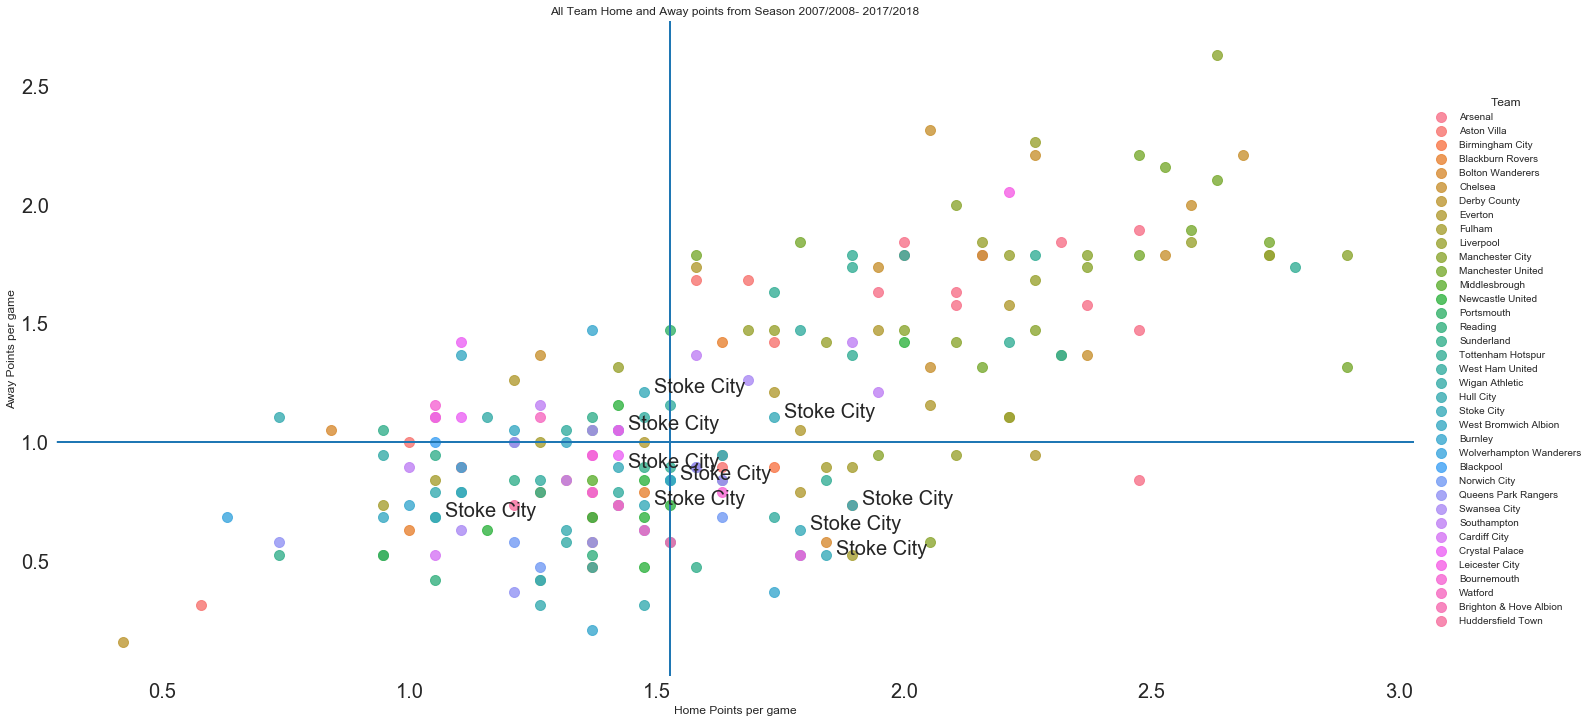

In [38]:
plt.rcParams['axes.facecolor'] = 'w'
rcParams['figure.figsize'] = 20,15
rcParams["scatter.marker"]='s'
ax = sns.lmplot('HomePPG','AwayPPG',data=Club_Pts,fit_reg=False, height = 10,aspect =2,hue='Team',scatter_kws={"s": 100})
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        if point['val']=='Stoke City':
            ax.text(point['x']+.02, point['y'], str(point['val']),fontsize=20)
            
plt.axvline(HomeMedian)
plt.axhline(AwayMedian)
  
plt.title('All Team Home and Away points from Season 2007/2008- 2017/2018')
# Set x-axis label
plt.xlabel('Home Points per game')
# Set y-axis label
plt.ylabel('Away Points per game')
 
label_point(Club_Pts.HomePPG, Club_Pts.AwayPPG, Club_Pts.Team, plt.gca())  

In [39]:
#Stoke City home games stats merged with weather data for each fixture
#Cities_wthr=['Stoke-on-Trent','London','Manchester','Liverpool']
def weather_by_city(df,Cities_wthr):
        df=df[df['City']==Cities_wthr]
        df['Date_Time']=pd.to_datetime(df['Date_Time'])
        df['Date']=pd.to_datetime(df['Date_Time'].dt.date)
        df['Time']=df['Date_Time'].dt.time
        df.drop(['Date_Time'],axis=1,inplace=True)
        df=df[['City','Date', 'Time','MintempC', 'MaxtempC', 'TempC', 'WindspeedKmph', 'WeatherDesc',
           'WinddirDegree', 'Winddir16Point', 'PrecipMM', 'Humidity', 'Visibility',
           'Pressure', 'Cloudcover', 'HeatIndexC', 'DewPointC', 'WindChillC',
           'WindGustKmph', 'FeelsLikeC', 'UvIndex']]
        return df   
            
Stoke_wthr=weather_by_city(weather,'Stoke-on-Trent')
London_wthr=weather_by_city(weather,'London')
Manchester_wthr=weather_by_city(weather,'Manchester')
Liverpool_wthr=weather_by_city(weather,'Liverpool')

Club_Fixtures_wthr=PremierLeague[['Season', 'Date','DayofWeek','Kickoff','HomeTeam','AwayTeam','HomeScore','AwayScore', 'Result','HomePoints','AwayPoints',
                                 'HomeFouls','AwayFouls']]
HME_Stoke_Fix=Club_Fixtures_wthr[Club_Fixtures_wthr['HomeTeam']=='Stoke City']
Stoke_wthr['City'] = Stoke_wthr['City'].map({'Stoke-on-Trent': 'Stoke City'})
HME_Stoke_Fix_wthr = pd.merge(HME_Stoke_Fix,Stoke_wthr, on ='Date',how='inner')
HME_Stoke_Fix_wthr.drop(['City','Time'],axis=1,inplace=True)
HME_Stoke_Fix_wthr.head(10)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vie

,Season,Date,DayofWeek,Kickoff,HomeTeam,AwayTeam,HomeScore,AwayScore,Result,HomePoints,AwayPoints,HomeFouls,AwayFouls,MintempC,MaxtempC,TempC,WindspeedKmph,WeatherDesc,WinddirDegree,Winddir16Point,PrecipMM,Humidity,Visibility,Pressure,Cloudcover,HeatIndexC,DewPointC,WindChillC,WindGustKmph,FeelsLikeC,UvIndex
0,08-09,2008-08-23,Saturday,15:00:00,Stoke City,Aston Villa,3,2,H,3,0,15,5,0.0,0.0,18.0,12.0,Overcast,210.0,SSW,0.0,64.0,10.0,1012.0,90.0,18.0,11.0,18.0,17.0,18.0,4.0
1,08-09,2008-09-14,Sunday,13:30:00,Stoke City,Everton,2,3,A,0,3,10,19,0.0,0.0,17.0,12.0,Partly cloudy,116.0,ESE,0.0,66.0,10.0,1025.0,42.0,17.0,11.0,17.0,14.0,17.0,5.0
2,08-09,2008-09-27,Saturday,15:00:00,Stoke City,Chelsea,0,2,A,0,3,9,6,0.0,0.0,17.0,9.0,Sunny,222.0,SW,0.0,59.0,10.0,1029.0,0.0,19.0,11.0,19.0,10.0,19.0,5.0
3,08-09,2008-10-19,Sunday,16:00:00,Stoke City,Tottenham Hotspur,2,1,H,3,0,12,12,0.0,0.0,12.0,26.0,Overcast,204.0,SSW,0.0,80.0,10.0,1011.0,95.0,12.0,9.0,9.0,40.0,9.0,3.0
4,08-09,2008-10-29,Wednesday,19:45:00,Stoke City,Sunderland,1,0,H,3,0,10,8,0.0,0.0,3.0,18.0,Overcast,161.0,SSE,0.0,82.0,10.0,1000.0,92.0,3.0,0.0,-1.0,30.0,-1.0,1.0
5,08-09,2008-11-22,Saturday,15:00:00,Stoke City,West Bromwich Albion,1,0,H,3,0,9,7,0.0,0.0,3.0,20.0,Sunny,342.0,NNW,0.0,61.0,10.0,1018.0,5.0,3.0,-4.0,-2.0,31.0,-2.0,2.0
6,08-09,2008-11-29,Saturday,15:00:00,Stoke City,Hull City,1,1,D,1,1,17,20,0.0,0.0,3.0,6.0,Cloudy,4.0,N,0.0,87.0,10.0,996.0,87.0,3.0,1.0,1.0,9.0,1.0,1.0
7,08-09,2008-12-13,Saturday,15:00:00,Stoke City,Fulham,0,0,D,1,1,16,2,0.0,0.0,3.0,4.0,Fog,208.0,SSW,0.0,100.0,0.0,986.0,100.0,3.0,3.0,2.0,7.0,2.0,1.0
8,08-09,2008-12-26,Friday,12:45:00,Stoke City,Manchester United,0,1,A,0,3,13,7,0.0,0.0,4.0,17.0,Sunny,100.0,E,0.0,78.0,10.0,1040.0,3.0,4.0,0.0,0.0,23.0,0.0,2.0
9,08-09,2009-01-31,Saturday,12:45:00,Stoke City,Manchester City,1,0,H,3,0,9,9,6.0,6.0,5.0,24.0,Sunny,109.0,ESE,0.0,63.0,10.0,1010.0,11.0,5.0,-1.0,1.0,39.0,1.0,3.0


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


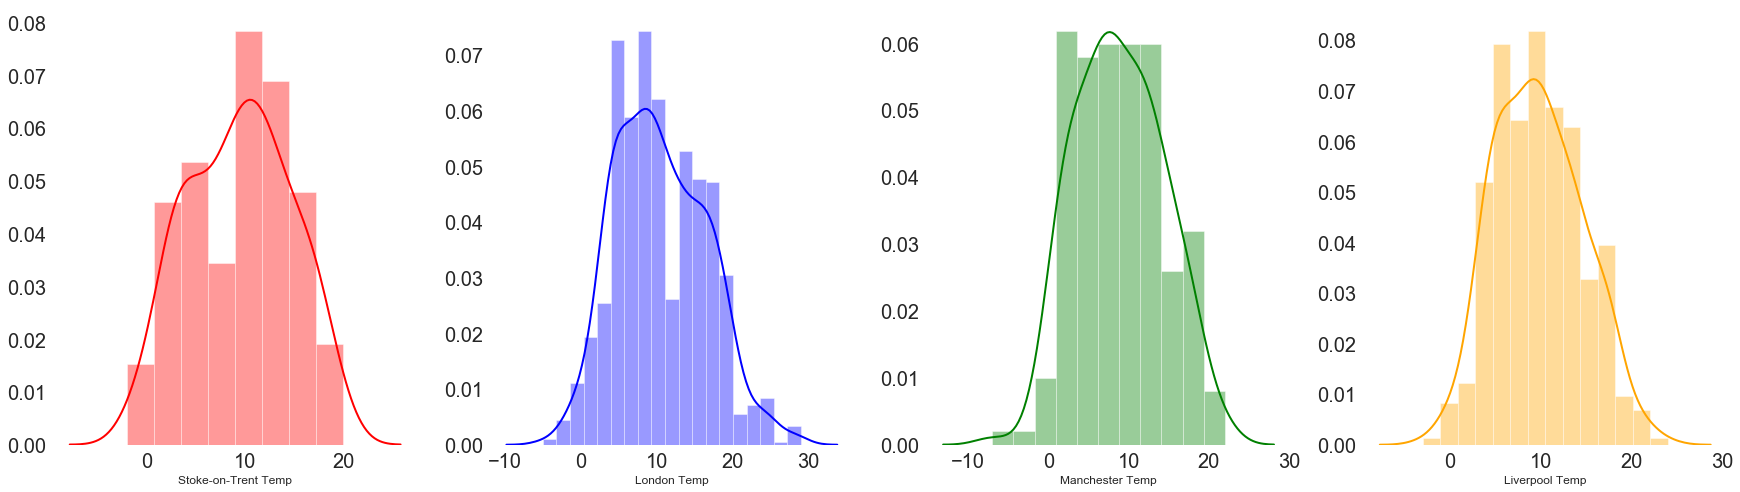

In [40]:
Liverpool_wthr.dropna(inplace=True)
London_wthr.dropna(inplace=True)
Manchester_wthr.dropna(inplace=True)
fig = plt.figure(figsize=(30,8))
plt.subplot(1,4,1)
sns.distplot(Stoke_wthr["TempC"].astype(int),color='red',axlabel='Stoke-on-Trent Temp')
plt.subplot(1,4,2)
sns.distplot(London_wthr["TempC"].astype(int),color='blue',axlabel='London Temp')
plt.subplot(1,4,3)
sns.distplot(Manchester_wthr["TempC"].astype(int),color='green',axlabel='Manchester Temp')
plt.subplot(1,4,4)
sns.distplot(Liverpool_wthr["TempC"].astype(int),color='orange',axlabel='Liverpool Temp')

plt.show()

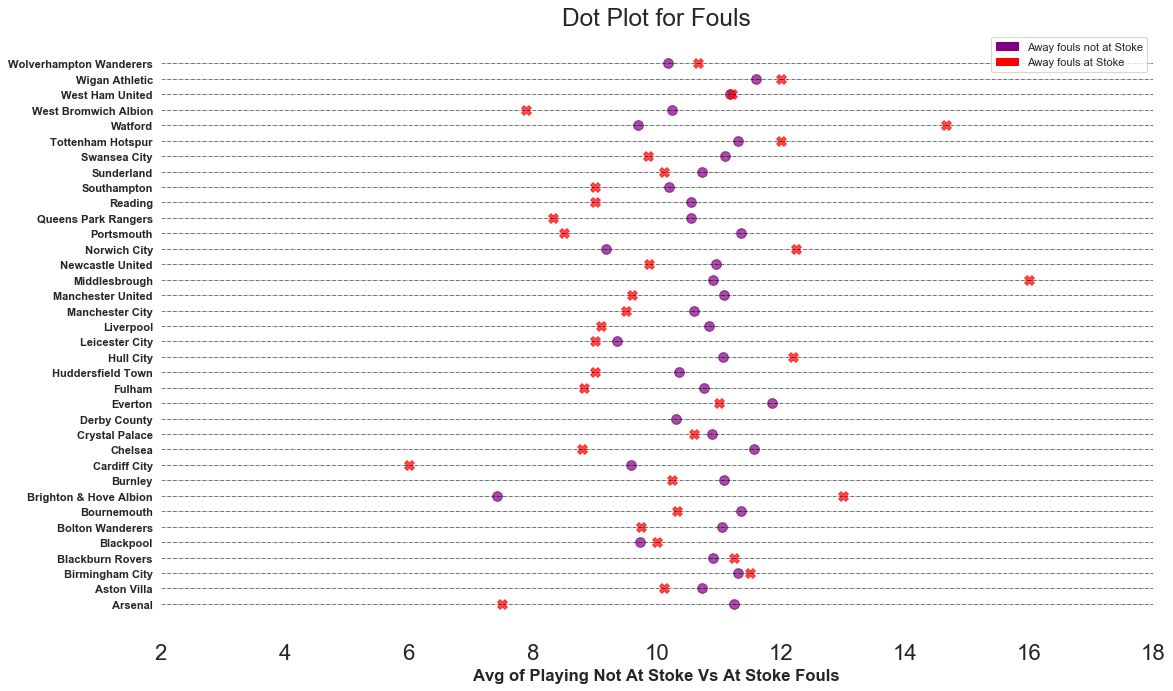

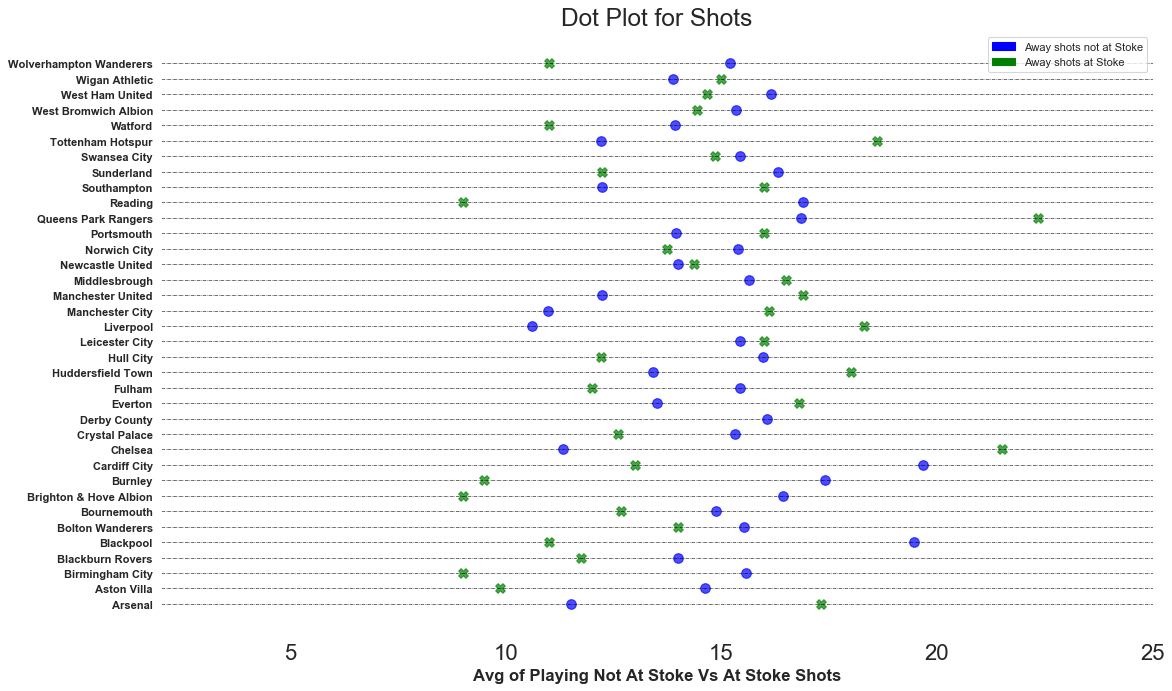

In [41]:
import matplotlib.patches as mpatches
Away_games=PremierLeague[PremierLeague['At_Stoke']==0].groupby(['AwayTeam']).mean()
Away_games.reset_index('AwayTeam',inplace=True)
AtStoke_games=PremierLeague[PremierLeague['At_Stoke']==1].groupby(['HomeTeam']).mean()
AtStoke_games.reset_index('HomeTeam',inplace=True)
# Draw plot
fig, ax = plt.subplots(figsize=(16,10), dpi= 80)
ax.hlines(y=Away_games.AwayTeam, xmin=2, xmax=18, color='black', alpha=1, linewidth=0.5, linestyles='dashdot')
ax.scatter(y=Away_games.AwayTeam, x=Away_games.HomeFouls, s=75, color='purple', alpha=0.7,marker='o')
ax.scatter(y=AtStoke_games.HomeTeam, x=AtStoke_games.HomeFouls, s=75, color='red', alpha=0.7,marker='X')

# Title, Label, Ticks and Ylim
ax.set_title('Dot Plot for Fouls', fontdict={'size':22})
ax.set_xlabel('Avg of Playing Not At Stoke Vs At Stoke Fouls',fontdict={'fontsize':15,'fontweight':'bold'})
ax.set_yticks(Away_games.AwayTeam)
ax.set_yticklabels(Away_games.AwayTeam.str.title(), fontdict={'horizontalalignment': 'right','fontsize':10,'fontweight':'bold'})
ax.set_xlim(2,18)
purple_patch = mpatches.Patch(color='purple', label='Away fouls not at Stoke')
red_patch = mpatches.Patch(color='red', label='Away fouls at Stoke')
plt.legend(handles=[purple_patch,red_patch])
plt.show()
# Draw plot
fig, ax = plt.subplots(figsize=(16,10), dpi= 80)
ax.hlines(y=Away_games.AwayTeam, xmin=2, xmax=25, color='black', alpha=1, linewidth=0.5, linestyles='dashdot')
ax.scatter(y=Away_games.AwayTeam, x=Away_games.HomeShots, s=75, color='blue', alpha=0.7,marker='o')
ax.scatter(y=AtStoke_games.HomeTeam, x=AtStoke_games.HomeShots, s=75, color='green', alpha=0.7,marker='X')

# Title, Label, Ticks and Ylim
ax.set_title('Dot Plot for Shots', fontdict={'size':22})
ax.set_xlabel('Avg of Playing Not At Stoke Vs At Stoke Shots',fontdict={'fontsize':15,'fontweight':'bold'})
ax.set_yticks(Away_games.AwayTeam)
ax.set_yticklabels(Away_games.AwayTeam.str.title(), fontdict={'horizontalalignment': 'right','fontsize':10,'fontweight':'bold'})
ax.set_xlim(2,25)
blue_patch = mpatches.Patch(color='blue', label='Away shots not at Stoke')
green_patch = mpatches.Patch(color='green', label='Away shots at Stoke')
plt.legend(handles=[blue_patch,green_patch])
plt.show()

<a id="Regression"></a>

## Regression

While on the face of it, our exploratory analysis of the data related to aspects of the phrase "cold, wet, Wednesday night in Stoke failed to show up any evidence to support the idea that was any truth to the notion that that combination was a particularly hard fixture to play, we wanted to take a different look and see if we could model our favoured response variables (AwayPoints, AwayShots and HomeFouls) and see if regression identified individual variables (or combinations) related to rain, temperature, day of the week and whether or not an away game was at Stoke or somewhere else as significant predictors of those response variables. 

An initial look at the pairs plot for a selection of variables didn't show any strrong or interesting correlations between our chosen response variables and possible predictors but the regression itself did throw up some interesting models.

/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


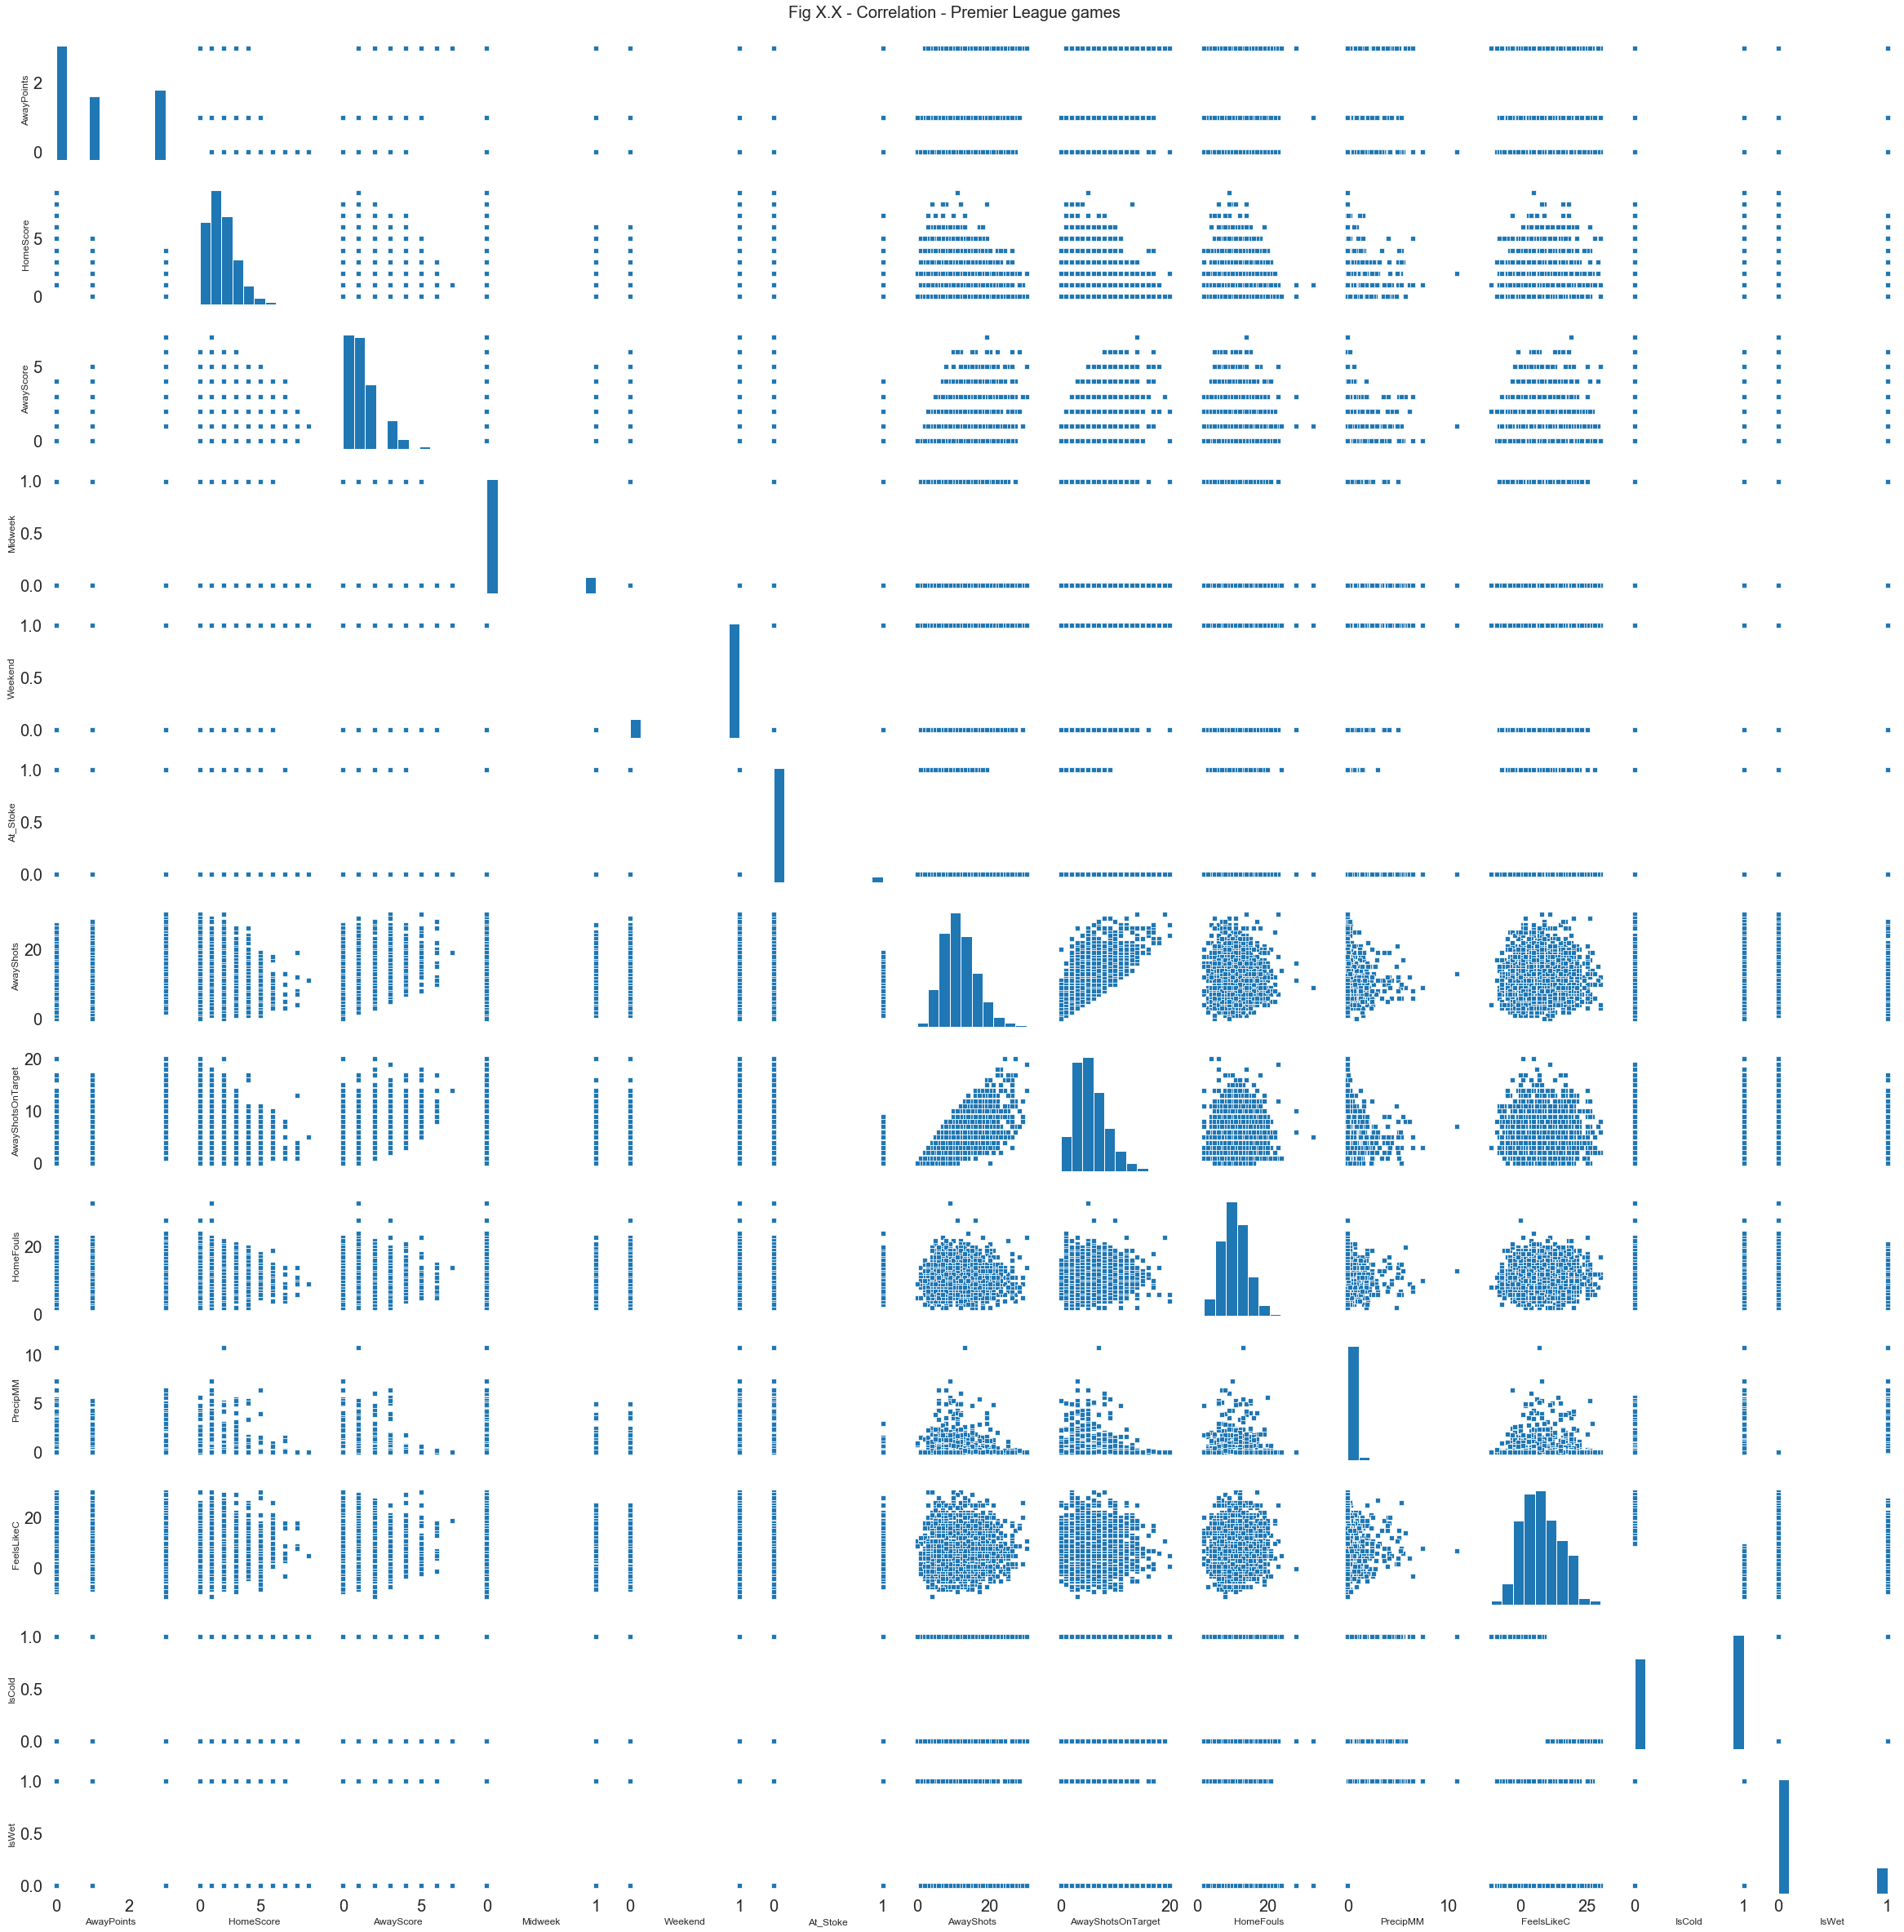

In [42]:
RegressionVariables = ['AwayPoints', 'HomeScore', 'AwayScore', 'Midweek', 'Weekend', 'At_Stoke', 
                           'AwayShots', 'AwayShotsOnTarget', 'HomeFouls', 'PrecipMM', 'FeelsLikeC', 'IsCold', 'IsWet']

sns.pairplot(PremierLeague[RegressionVariables])
_ = plt.suptitle('Fig X.X - Correlation - Premier League games', y=1.01, fontsize=20)

Using Teo's backwards regression model as the basis, we looked at whether certain weather and dayofweek variables or combinations thereof would make it into the model for the three reponse variables we selected.

The dummy variable 'At_Stoke' makes the cut (based on p-values) into all three but while the model and that particular variable is statistically significant the coefficent of -0.2 points won by the away team if the game is at Stoke is not earth shattering, and the notions of 'cold', 'wet, or 'Wednesday night' don't feature in the model. Two of those do feature in the model for AwayShots - a measure of opportunities created by the away team and a proxy for their dominance or otherwise. The number of shots tends to decrease by 0.2911 with every millimetre of preciptation and playing at Stoke as opposed to elsewhere decreases shots by 2.3 which is not to be sniffed at but overall th emodel explains less than 2% of the total variance so it is hard to put much weight on these results.

In [43]:
def stepwise_backwards_regression(response_var, exp_vars, df):
    while len(exp_vars) > 0:
        forml = response_var + ' ~ 1 +' + ' + '.join(exp_vars)
#         print(forml)
        model = smf.ols(formula= forml, data=df).fit()

        sorted_ps = model.pvalues.sort_values(ascending=False).drop('Intercept')
        if (sorted_ps[0]) > 0.05:
            exp_vars = sorted_ps.index[1:].values
            drop = sorted_ps.index[0]
#             print(str(len(exp_vars)) + ' var model AIC: ' + str(model.aic) + ', adj Rsq: ' + str(model.rsquared_adj))
#             print('Dropped: ' + drop + ' with p-value ' + str(round(sorted_ps[0],3)))
        else:
            print(forml)
            return model
    print(forml)
    return model

def backwards_regression_Stoke(response_var):
    return stepwise_backwards_regression(response_var, 
                                         ['Midweek','At_Stoke', 'PrecipMM', 'IsWet', 'IsCold', 'FeelsLikeC', 'IsWet*IsCold', 'Midweek*IsCold', 'IsWet*Midweek', 'IsWet*Midweek*IsCold'], 
                                         PremierLeague[['Midweek','At_Stoke', 'PrecipMM', 'IsWet', 'IsCold', 'FeelsLikeC', response_var]].dropna())

In [44]:
mod_AwayPoints = backwards_regression_Stoke('AwayPoints')
mod_AwayShots = backwards_regression_Stoke('AwayShots')
mod_HomeFouls = backwards_regression_Stoke('HomeFouls')

AwayPoints ~ 1 +At_Stoke
AwayShots ~ 1 +FeelsLikeC + PrecipMM + At_Stoke
HomeFouls ~ 1 +Midweek + IsWet:IsCold + At_Stoke + FeelsLikeC


In [45]:
print("Away points regression model\n", mod_AwayPoints.summary(), "\n\n")
print("Away shots regression model\n", mod_AwayShots.summary(), "\n\n")
print("Home fouls regression model\n",mod_HomeFouls.summary(), "\n\n")

Away points regression model
                             OLS Regression Results                            
Dep. Variable:             AwayPoints   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     9.047
Date:                Tue, 28 May 2019   Prob (F-statistic):            0.00265
Time:                        21:41:42   Log-Likelihood:                -6267.9
No. Observations:                3800   AIC:                         1.254e+04
Df Residuals:                    3798   BIC:                         1.255e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1241 

<a id="Conclusion"></a>
## Conclusions

We have found very little evidence to convicne us that there is much truth to the idea that playing "on a cold, wet, Wednesday night in Stoke" is a particularly challenging fixture and what began as a rather pompousm possibly thowaway line in a football broadcast but took on a life of it's own, can safely be retured from any serious football discussions.

<a id="Limitations"></a>

## Limitations

<a id="Data_Sources"></a>
## Data Sources 
Fixtures with date and time: https://www.kaggle.com/acmfootball/premier-league-football-data-200708201718

Results with extra stats https://www.kaggle.com/thefc17/epl-results-19932018

Tables: https://www.kaggle.com/limmen/premierleague-league-tables-188889-201617

Weather API: https://www.worldweatheronline.com

Gopher image, Credit Ashley McNamara https://github.com/ashleymcnamara/gophers

<a id="References"></a>
## References

1. https://www.goal.com/en-us/news/85/england/2010/12/21/2271248/top-epl-journalist-andy-gray-lionel-messi-is-not-good-enough-for-
2. https://www.telegraph.co.uk/sport/11611106/The-10-most-enduring-football-debates.html?frame=3307440
3. https://www.sportskeeda.com/football/review-cold-night-in-stoke

[Return to top](#Home)

<a id="Extras"></a>
## Stuff we don't need just yet

In [46]:
#PremierLeague.head(20)
Stoke_HMfixtures=PremierLeague[PremierLeague.HomeTeam=='Stoke City']
Stoke_AWfixtures=PremierLeague[PremierLeague.AwayTeam=='Stoke City']
# Stoke_HMfixtures.loc[:,'Date_Time'] = Stoke_HMfixtures.loc[:,'Date_Time'].apply(pd.to_datetime)
# Stoke_AWfixtures.loc[:,'Date_Time'] = Stoke_AWfixtures.loc[:,'Date_Time'].apply(pd.to_datetime)
#Stoke_HMfixtures.info()
#Stoke_HMfixtures.head()


Text(0.5, 1.0, 'Stoke City Away Fixtures')

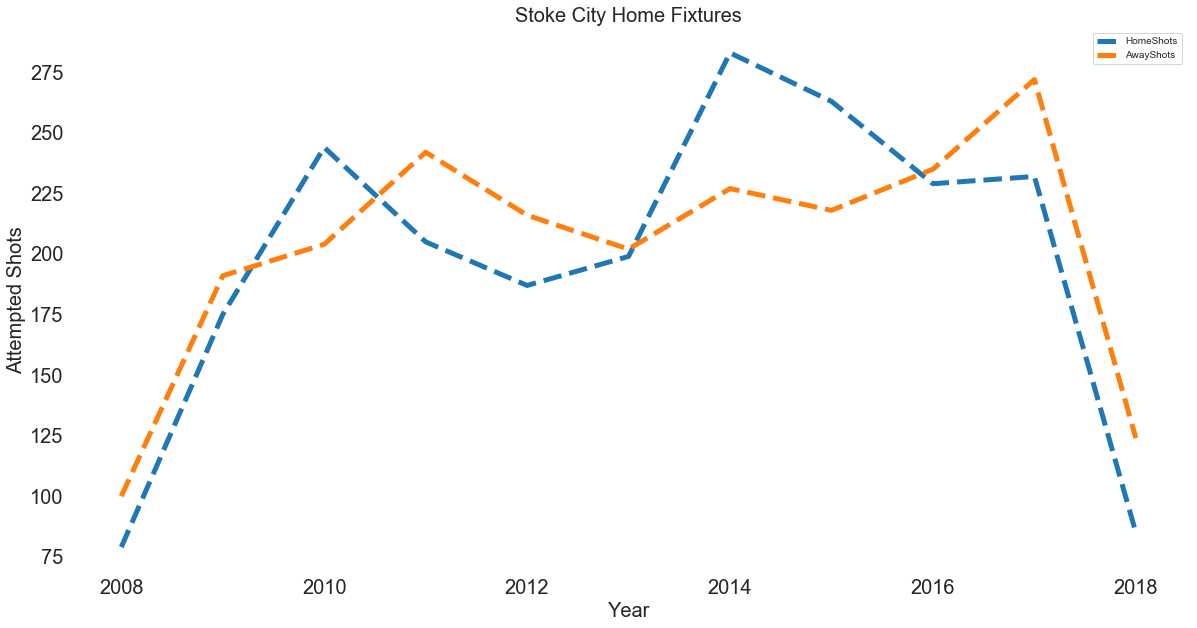

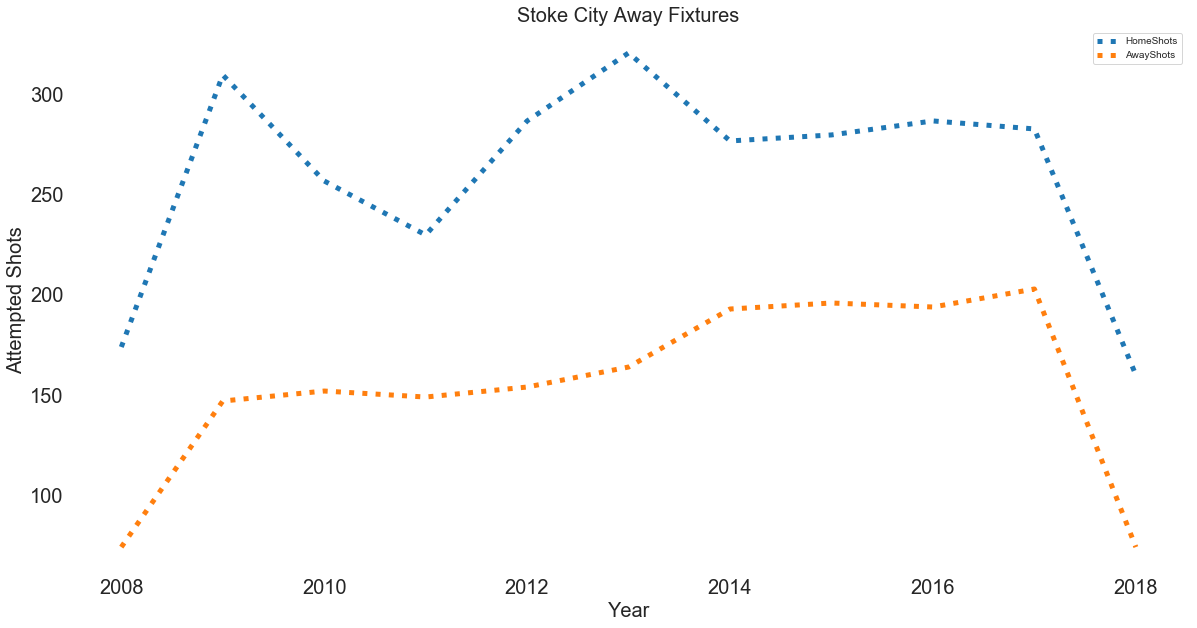

In [47]:
col=['HomeShots','AwayShots','HomeShotsOnTarget','AwayShotsOnTarget']
def create_shots_df(df,c):
    n_df=pd.DataFrame(df['Date'])
    for c in col:
        new_df=pd.DataFrame(df.groupby(df['Date'].dt.year)[col].sum())
    return new_df      
                                         
HM_shots=create_shots_df(Stoke_HMfixtures,col)
AW_shots=create_shots_df(Stoke_AWfixtures,col)
HM_shots
#AW_shots
plt.rcParams['axes.facecolor'] = 'w'
HM_shots[['HomeShots', 'AwayShots']].plot(figsize=(20,10), linewidth=5, fontsize=20,ls='--')
plt.xlabel('Year', fontsize=20)
plt.ylabel('Attempted Shots',fontsize=20)
#plt.legend(['Home Team shots_total','Away Team shots_total','Home Team shots_on_target_total','Away Team shots_on_target_total'],facecolor='white')
plt.title('Stoke City Home Fixtures',fontsize=20)
AW_shots[['HomeShots', 'AwayShots']].plot(figsize=(20,10), linewidth=5, fontsize=20,ls=':')
plt.xlabel('Year', fontsize=20)
plt.ylabel('Attempted Shots',fontsize=20)
#plt.legend(['Home Team shots_total','Away Team shots_total','Home Team shots_on_target_total','Away Team shots_on_target_total'],facecolor='white')
plt.title('Stoke City Away Fixtures',fontsize=20)

In [48]:
Club_Pts_Stoke=Club_Pts[Club_Pts['Team']=='Stoke City']
Club_Pts_Stoke=Club_Pts_Stoke.set_index(['Season'])
Club_Pts_Stoke.index.unique()

Index(['08-09', '09-10', '10-11', '11-12', '12-13', '13-14', '14-15', '15-16',
       '16-17', '17-18'],
      dtype='object', name='Season')

In [49]:
# plt.style.use('ggplot')
# plt.rcParams['figure.figsize']=(15,10)
# plt.rcParams.update({'font.size':20})
# Stoke_Home= Club_Pts_Stoke['HomePoints']
# Stoke_Away= Club_Pts_Stoke['AwayPoints']
# fig, ax = plt.subplots()
# index = np.arange(len(Club_Pts_Stoke.index))
# bar_width = 0.25
# opacity = 0.9
# ax.bar(index, Stoke_Home, bar_width, alpha=opacity, color='g',
#                 label='Home')
# ax.bar(index+bar_width, Stoke_Away, bar_width, alpha=opacity, color='b',
#                 label='Away')
# ax.set_xlabel('Premier League Seasons')
# ax.set_ylabel('Points')
# ax.set_title('Stoke City Points-Home v/s Points-Away')
# ax.set_xticks(index + bar_width / 2)
# ax.set_xticklabels(Club_Pts_Stoke.index.unique())
# ax.legend()
# plt.show()

In [50]:
#Liverpool_wthr.isna().count()
#HME_Stoke_Fix_wthr.info()
#HME_Stoke_Fix_wthr.set_index('Kickoff')
HME_Stoke_Fix_wthr['Date_time']=pd.to_datetime(HME_Stoke_Fix_wthr['Date'].astype(str)+' '+HME_Stoke_Fix_wthr['Kickoff'].astype(str))
HME_Stoke_Fix_wthr.set_index('Date_time',inplace=True)
HME_Stoke_Fix_wthr.head()
Stoke_nights=HME_Stoke_Fix_wthr.between_time('16:00', '23:00')
#Stoke_nights=Stoke_nights[Stoke_nights['TempC']<10]
#Stoke_nights[(Stoke_nights['WeatherDesc']!='Sunny') &  (Stoke_nights['TempC']<10)]
Stoke_nights.groupby(['Result'])['Result'].count()
Stoke_nights['AwayTeam'].unique()
#Stoke_nights

array(['Tottenham Hotspur', 'Sunderland', 'Portsmouth', 'Fulham',
       'Manchester City', 'Arsenal', 'Aston Villa', 'Liverpool',
       'West Bromwich Albion', 'Wolverhampton Wanderers',
       'Wigan Athletic', 'Manchester United', 'Newcastle United',
       'Swansea City', 'Chelsea', 'Norwich City', 'Southampton',
       'Watford'], dtype=object)

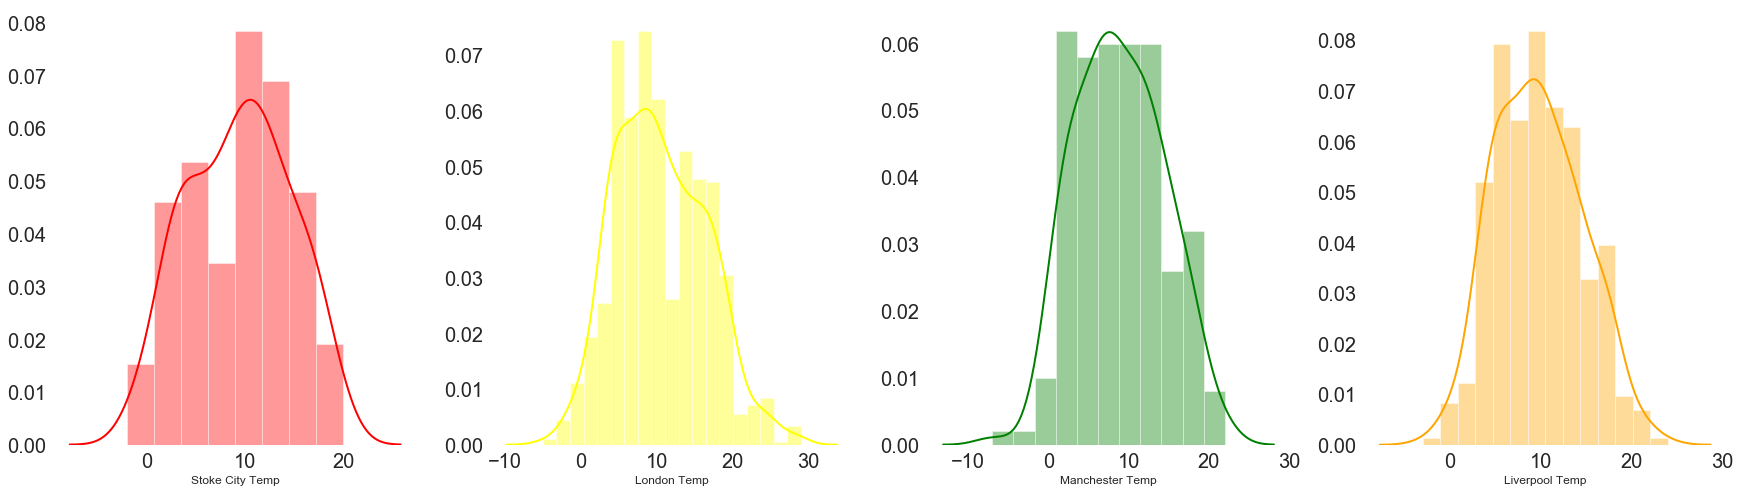

In [51]:
Liverpool_wthr.dropna(inplace=True)
London_wthr.dropna(inplace=True)
Manchester_wthr.dropna(inplace=True)
fig = plt.figure(figsize=(30,8))
plt.subplot(1,4,1)
sns.distplot(Stoke_wthr["TempC"].astype(int),color='red',axlabel='Stoke City Temp')
plt.subplot(1,4,2)
sns.distplot(London_wthr["TempC"].astype(int),color='yellow',axlabel='London Temp')
plt.subplot(1,4,3)
sns.distplot(Manchester_wthr["TempC"].astype(int),color='green',axlabel='Manchester Temp')
plt.subplot(1,4,4)
sns.distplot(Liverpool_wthr["TempC"].astype(int),color='orange',axlabel='Liverpool Temp')

plt.show()

In [52]:
print(PremierLeague.loc[(PremierLeague['AwayTeam']=='Arsenal') & (PremierLeague['HomeTeam']== 'Stoke City')]['AwayFouls'].mean())
print(PremierLeague.loc[(PremierLeague['AwayTeam']=='Arsenal') & (PremierLeague['HomeTeam']== 'Manchester City')][['AwayFouls','HomeFouls']].mean())
#PremierLeague.loc[PremierLeague['HomeTeam']=='Stoke City'].count()
#ARS[ARS['HomeTeam']=='Chelsea']
foul_avg=[]
Away_list=['Tottenham Hotspur', 'Sunderland', 'Portsmouth', 'Fulham',
       'Manchester City', 'Arsenal', 'Aston Villa', 'Liverpool',
       'West Bromwich Albion', 'Wolverhampton Wanderers',
       'Wigan Athletic', 'Manchester United', 'Newcastle United',
       'Swansea City', 'Chelsea', 'Norwich City', 'Southampton',
       'Watford']
#df2=pd.DataFrame(PremierLeague.loc[PremierLeague['AwayTeam']=='Arsenal']['HomeTeam'].unique())
for p in Away_list:
    t_p=PremierLeague.loc[PremierLeague['AwayTeam']==p]['HomeTeam'].unique()
    df2=pd.DataFrame(t_p)
    #new_df=pd.DataFrame(t_p)
    for t in t_p:
        #print(PremierLeague.loc[(PremierLeague['AwayTeam']=='Arsenal') & (PremierLeague['HomeTeam']== t)]['AwayFouls'].mean())
        foul_avg.append(PremierLeague.loc[(PremierLeague['AwayTeam']=='Arsenal') & (PremierLeague['HomeTeam']== t)]['AwayFouls'].mean() )
    df1=pd.DataFrame(t_p)    
    df1[p] =foul_avg 
    #print(df1[p])
    temp=df1
#     df1.clear()
    foul_avg.clear()
    #df1.rename(index=str, columns={0: "Team at Home"})
    new_df=pd.merge(left=temp, right=df1, on=0, how="outer")
    
new_df    

#print(df2)

9.6
AwayFouls     9.454545
HomeFouls    12.272727
dtype: float64


,0,Watford_x,Watford_y
0,Everton,11.636364,11.636364
1,Manchester City,9.454545,9.454545
2,Newcastle United,10.000000,10.000000
3,Bournemouth,10.000000,10.000000
4,Stoke City,9.600000,9.600000
5,Leicester City,9.250000,9.250000
6,Aston Villa,9.333333,9.333333
7,Sunderland,10.600000,10.600000
8,Chelsea,12.363636,12.363636
9,Southampton,6.833333,6.833333


In [53]:
#def aggregate_team_attr(df,Team_Away,attr):
#foul_avg


Text(6.799999999999997, 0.5, 'Points won by away team')

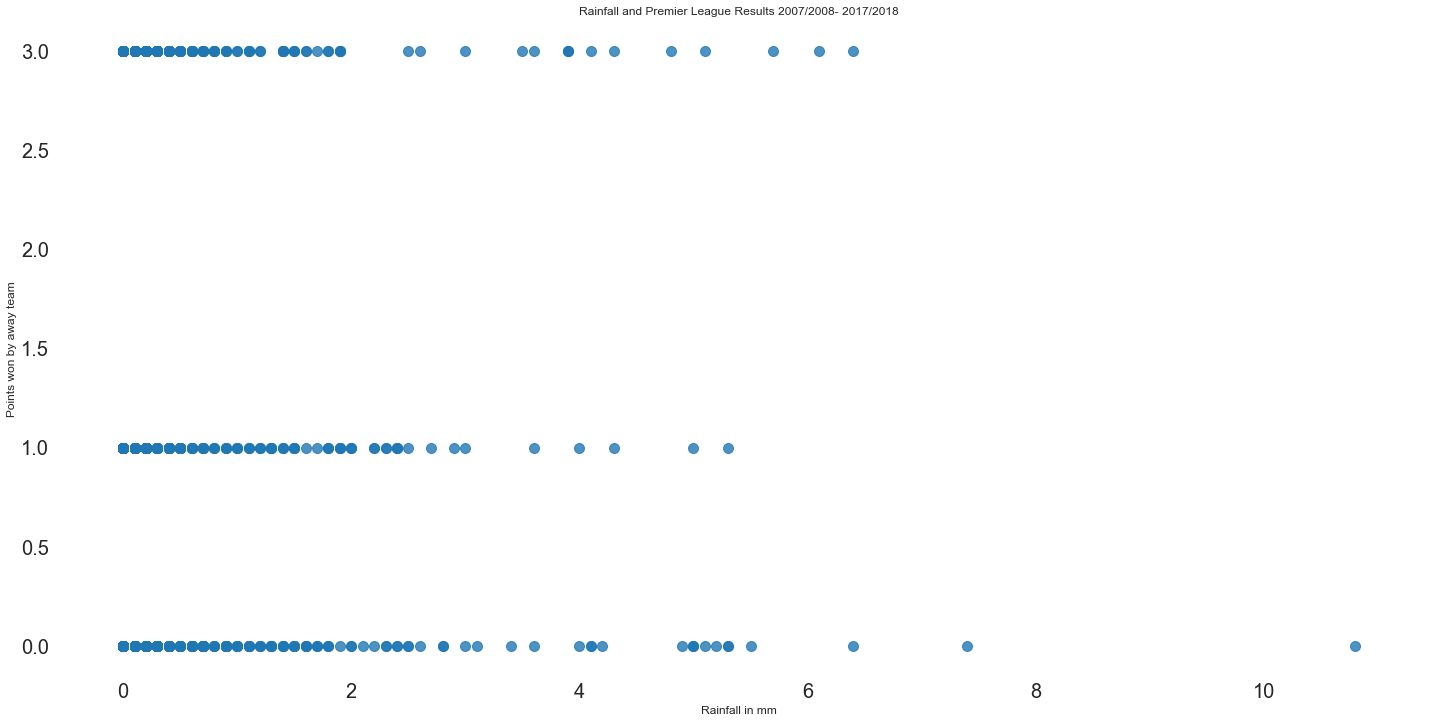

In [54]:
plt.rcParams['axes.facecolor'] = 'w'
rcParams['figure.figsize'] = 20,15
rcParams["scatter.marker"]='s'
ax = sns.lmplot('PrecipMM','AwayPoints', data=PremierLeague,fit_reg=False, height = 10,aspect =2,scatter_kws={"s": 100})
# def label_point(x, y, val, ax):
#     a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
#     for i, point in a.iterrows():
#         if point['val']=='Stoke City':
#             ax.text(point['x']+.02, point['y'], str(point['val']),fontsize=20)
  
plt.title('Rainfall and Premier League Results 2007/2008- 2017/2018')
# Set x-axis label
plt.xlabel('Rainfall in mm')
# Set y-axis label
plt.ylabel('Points won by away team')


Text(6.799999999999997, 0.5, 'Points won by away team')

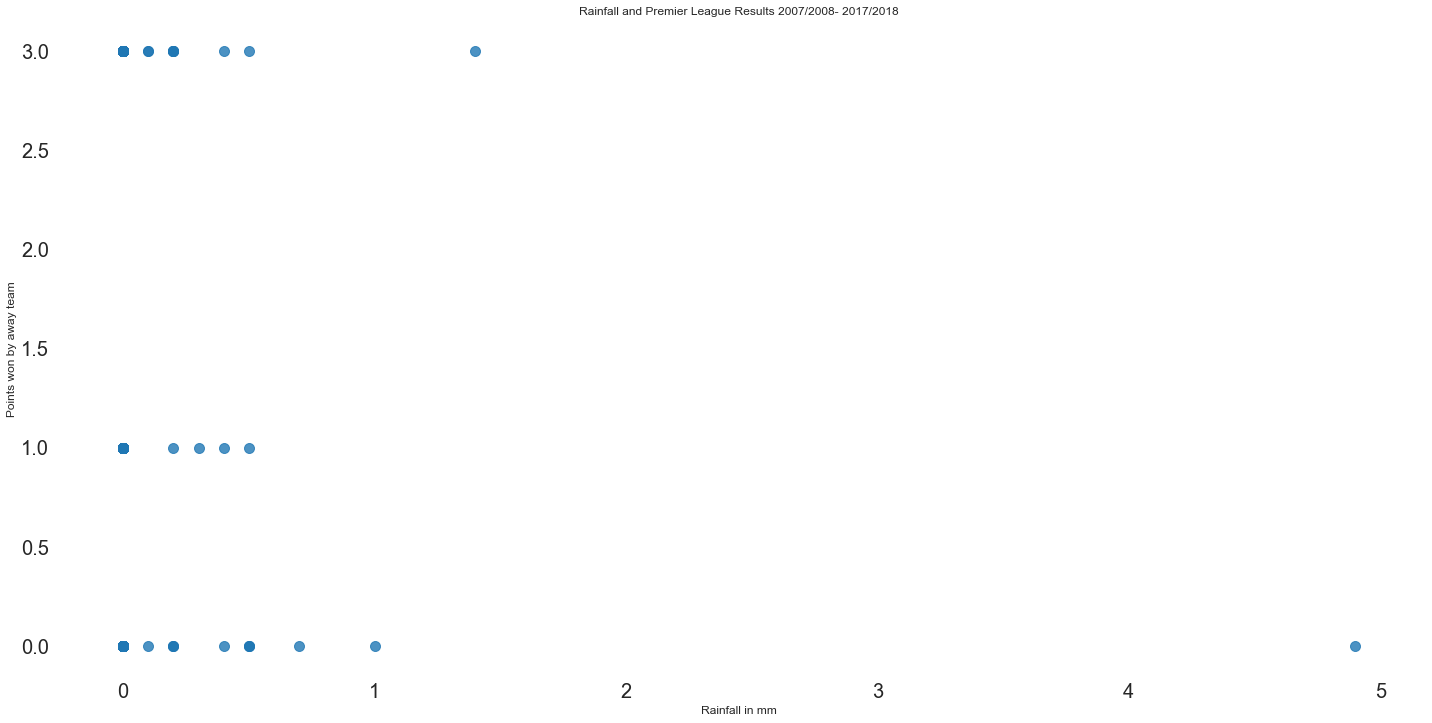

In [55]:
plt.rcParams['axes.facecolor'] = 'w'
rcParams['figure.figsize'] = 20,15
rcParams["scatter.marker"]='s'
ax = sns.lmplot('PrecipMM','AwayPoints', data=HME_Stoke_Fix_wthr, fit_reg=False, height = 10,aspect =2,scatter_kws={"s": 100})
# def label_point(x, y, val, ax):
#     a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
#     for i, point in a.iterrows():
#         if point['val']=='Stoke City':
#             ax.text(point['x']+.02, point['y'], str(point['val']),fontsize=20)
  
plt.title('Rainfall and Premier League Results 2007/2008- 2017/2018')
# Set x-axis label
plt.xlabel('Rainfall in mm')
# Set y-axis label
plt.ylabel('Points won by away team')



Text(6.799999999999997, 0.5, 'Points won by away team')

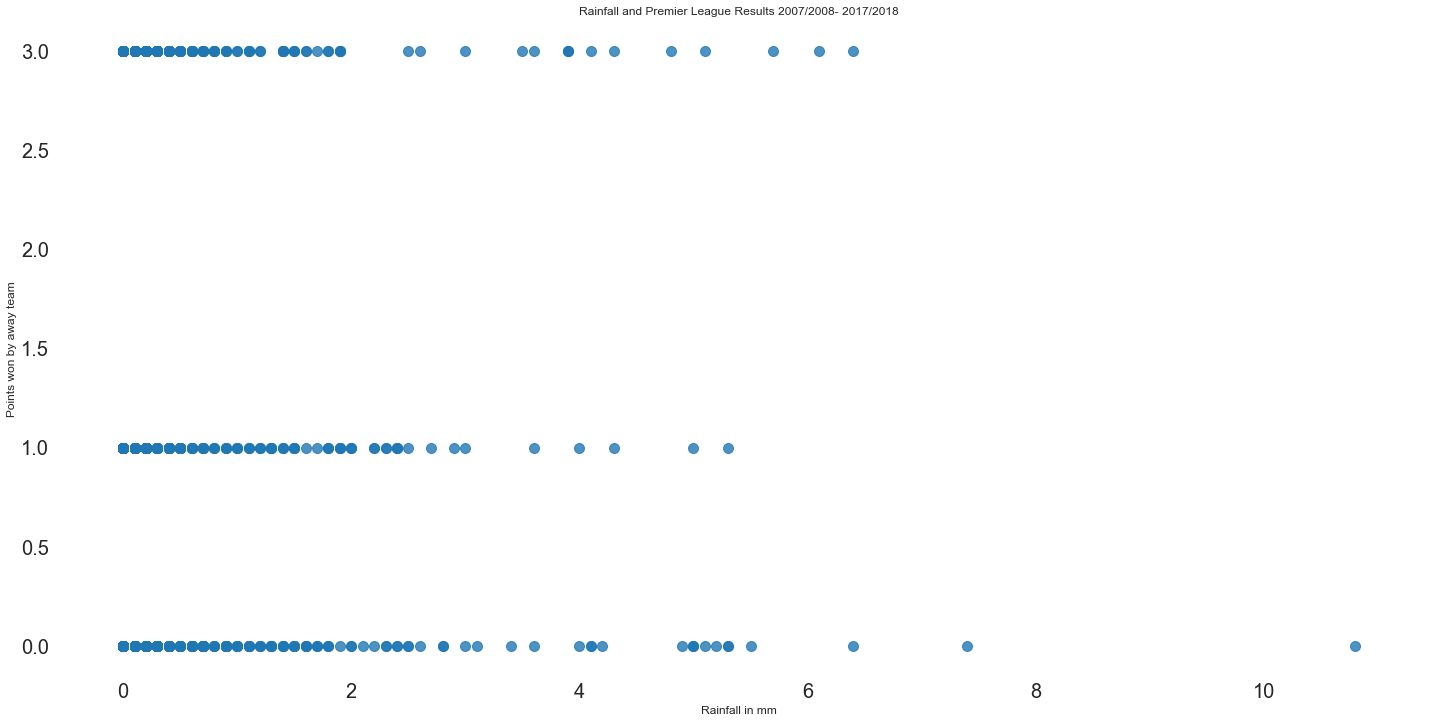

In [56]:
plt.rcParams['axes.facecolor'] = 'w'
rcParams['figure.figsize'] = 20,15
rcParams["scatter.marker"]='s'
ax = sns.lmplot('PrecipMM','AwayPoints', data=PremierLeague,fit_reg=False, height = 10,aspect =2,scatter_kws={"s": 100})
# def label_point(x, y, val, ax):
#     a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
#     for i, point in a.iterrows():
#         if point['val']=='Stoke City':
#             ax.text(point['x']+.02, point['y'], str(point['val']),fontsize=20)
  
plt.title('Rainfall and Premier League Results 2007/2008- 2017/2018')
# Set x-axis label
plt.xlabel('Rainfall in mm')
# Set y-axis label
plt.ylabel('Points won by away team')


In [57]:
PremierLeague.columns.unique()

Index(['Season', 'Date', 'Kickoff', 'HomeTeam', 'AwayTeam', 'HomeScore',
       'AwayScore', 'HomePoints', 'AwayPoints', 'Result', 'Result_Class',
       'City', 'Attendance', 'DayofWeek', 'Midweek', 'Weekend', 'At_Stoke',
       'HomeShots', 'AwayShots', 'HomeShotsOnTarget', 'AwayShotsOnTarget',
       'HomeFouls', 'AwayFouls', 'HomeCorners', 'AwayCorners', 'HomeYellows',
       'AwayYellows', 'HomeReds', 'AwayReds', 'MintempC', 'MaxtempC', 'TempC',
       'WindspeedKmph', 'WeatherDesc', 'WinddirDegree', 'Winddir16Point',
       'PrecipMM', 'Humidity', 'Visibility', 'Pressure', 'Cloudcover',
       'HeatIndexC', 'DewPointC', 'WindChillC', 'WindGustKmph', 'FeelsLikeC',
       'UvIndex', 'IsCold', 'IsWet'],
      dtype='object')

In [58]:
PremierLeague

,Season,Date,Kickoff,HomeTeam,AwayTeam,HomeScore,AwayScore,HomePoints,AwayPoints,Result,Result_Class,City,Attendance,DayofWeek,Midweek,Weekend,At_Stoke,HomeShots,AwayShots,HomeShotsOnTarget,AwayShotsOnTarget,HomeFouls,AwayFouls,HomeCorners,AwayCorners,HomeYellows,AwayYellows,HomeReds,AwayReds,MintempC,MaxtempC,TempC,WindspeedKmph,WeatherDesc,WinddirDegree,Winddir16Point,PrecipMM,Humidity,Visibility,Pressure,Cloudcover,HeatIndexC,DewPointC,WindChillC,WindGustKmph,FeelsLikeC,UvIndex,IsCold,IsWet
0,07-08,2007-08-11,12:45:00,Sunderland,Tottenham Hotspur,1,0,3,0,H,0,Sunderland,43967,Saturday,0,1,0,9,6,4,3,14,14,7,2,1,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,07-08,2007-08-11,15:00:00,Bolton Wanderers,Newcastle United,1,3,0,3,A,2,Bolton,25414,Saturday,0,1,0,13,7,9,5,15,16,4,3,1,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2,07-08,2007-08-11,15:00:00,Derby County,Portsmouth,2,2,1,1,D,1,Derby,32176,Saturday,0,1,0,12,12,5,6,14,17,6,6,1,2,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
3,07-08,2007-08-11,15:00:00,Everton,Wigan Athletic,2,1,3,0,H,0,Liverpool,39220,Saturday,0,1,0,12,14,8,4,8,13,6,2,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
4,07-08,2007-08-11,15:00:00,Middlesbrough,Blackburn Rovers,1,2,0,3,A,2,Middlesbrough,25058,Saturday,0,1,0,10,4,6,4,16,16,13,3,3,4,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
5,07-08,2007-08-11,15:00:00,West Ham United,Manchester City,0,2,0,3,A,2,London,34921,Saturday,0,1,0,9,14,2,5,13,11,5,3,0,4,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
6,07-08,2007-08-11,17:15:00,Aston Villa,Liverpool,1,2,0,3,A,2,Birmingham,42640,Saturday,0,1,0,10,17,6,7,18,11,4,2,4,2,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
7,07-08,2007-08-12,12:00:00,Arsenal,Fulham,2,1,3,0,H,0,London,60093,Sunday,0,1,0,19,12,13,9,6,19,14,4,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
8,07-08,2007-08-12,13:30:00,Chelsea,Birmingham City,3,2,3,0,H,0,London,41590,Sunday,0,1,0,19,6,11,4,8,8,5,3,2,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
9,07-08,2007-08-12,16:00:00,Manchester United,Reading,0,0,1,1,D,1,Trafford,75655,Sunday,0,1,0,22,3,9,2,8,16,12,3,0,2,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


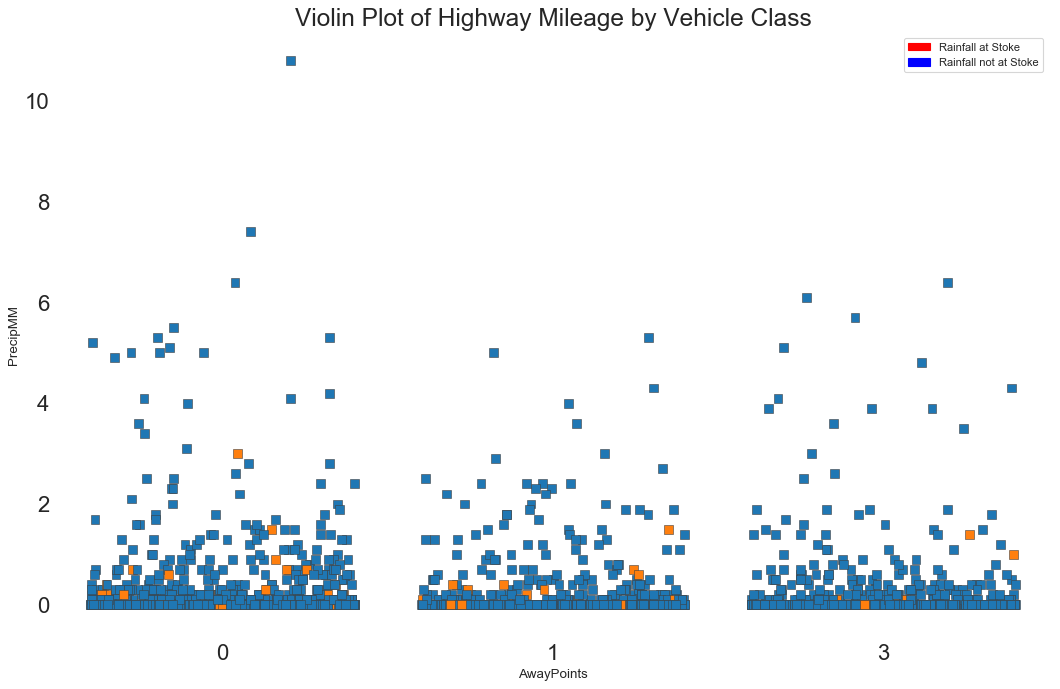

In [60]:
# Draw Plot
fig, ax = plt.subplots(figsize=(16,10), dpi= 80)    
sns.stripplot(x='AwayPoints',y='PrecipMM',hue='At_Stoke',data=PremierLeague, jitter=0.4, size=8, ax=ax, linewidth=.5)
# Decoration
plt.title('Violin Plot of Highway Mileage by Vehicle Class', fontsize=22)
blue_patch = mpatches.Patch(color='blue', label='Rainfall not at Stoke')
red_patch = mpatches.Patch(color='red', label='Rainfall at Stoke')
plt.legend(handles=[red_patch,blue_patch])
plt.show()

/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


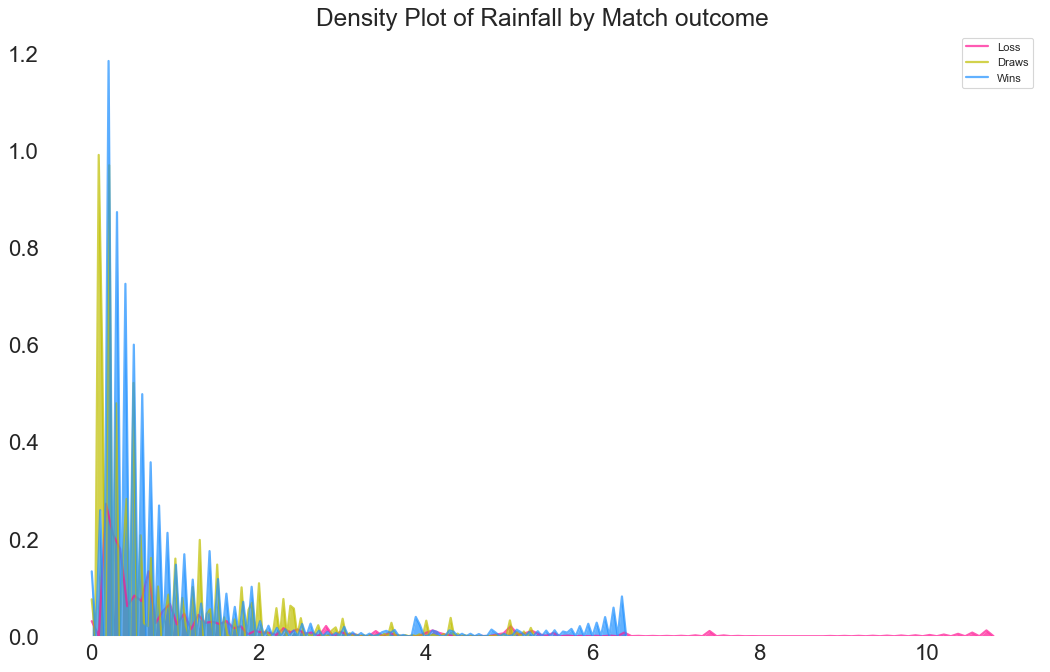

In [61]:
# Draw Plot
plt.figure(figsize=(16,10), dpi= 80)
sns.kdeplot(PremierLeague.loc[PremierLeague['AwayPoints'] == 0,"PrecipMM"], shade=True, color="deeppink", label="Loss", alpha=.7)
sns.kdeplot(PremierLeague.loc[PremierLeague['AwayPoints'] == 1,"PrecipMM"], shade=True, color="y", label="Draws", alpha=.7)
sns.kdeplot(PremierLeague.loc[PremierLeague['AwayPoints'] == 3,"PrecipMM"], shade=True, color="dodgerblue", label="Wins", alpha=.7)
# Decoration
plt.title('Density Plot of Rainfall by Match outcome', fontsize=22)
plt.legend()
plt.show()